# TFM

## Tabla de contenidos

* [1. Objetivo](#cap1)
    * [1.1. Participantes](#section_1_1)
* [2. Librerías y carga de datos](#cap2)
* [3. Feature engineering](#cap3)
* [4. EDA](#cap4)
    * [4.1. EDA reddit](#section_4_1)
    * [4.2. EDA precio GME](#section_4_1)
* [5. Análisis sentimientos](#cap5)
    * [5.1. Clasificación sentimientos títulos](#section_5_1)
        * [5.1.1. Modelo BERT](#section_5_1_1)
        * [5.1.2. Librería NLTK](#section_5_1_2)
    * [5.2. Clasificación sentimientos post](#section_5_2)
        * [5.2.1. Modelo BERT](#section_5_2_1)
        * [5.2.2. Librería NLTK](#section_5_2_2)
    * [5.3. Análisis relación sentimientos y precios de la acción](#section_5_3)
* [6. Análisis sentimientos post](#cap6)
* [7. Conclusiones](#cap7)

## 1. Objetivo <a class="anchor" id="cap1"></a>

Este proyecto tiene como propósito que los estudiantes identifiquen un problema abierto en el área del análisis de datos apoyado por técnicas de Inteligencia Artificial en el ámbito de su preferencia (Educación, ambiente, criminología, gobierno, etc.). Una vez identificado el problema el estudiante aplicará los conocimientos y competencias, vistos y adquiridos en el Master para hacer un tratamiento de datos al nivel que escoja (Descriptivo, diagnóstico, predictivo, prescriptivo).

### 1.1. Participantes <a class="anchor" id="section_1_1"></a>

* Mireya Harillo Gámez
* Óscar Tienda Beteta
* Henry Ocaña Luna
* David de la Torre Amengual

## 2. Librerías y carga de datos <a class="anchor" id="cap2"></a>

In [106]:
!pip install mplfinance
!pip install transformers
!pip install wordcloud

In [107]:
import numpy as np
import pandas as pd # Tratamiento de datos en formato tabular
import matplotlib.pyplot as plt #Visualizaciones
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns # Visualizaciónes
import IPython # Leer imágenes desde URL
import mplfinance as mpf #Gráficos de velas
import torch 
#import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os.path # Comprobación de existencia de ficheros
from datetime import datetime # Consultar fecha actual
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re # Tratamiento de expresiones regulares
import io # Convertir imágenes con texto en texto raw
import requests # Abrir imágenes desde URLS
from PIL import Image
from wordcloud import WordCloud,STOPWORDS #Generar nubes de palabras

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


La librería pytesseract requiere de la librería tesseract que es una librería no phyton que a su vez requiere de un ejecutable .exe. Además, la librería tesseract presenta problemas de compatibilidad con el environment común, por lo cual estas dos librerías estan en un environment diferenciado tesseract.ylm.

In [108]:
#import pytesseract # Convertir imágenes con texto en texto raw
#pytesseract.pytesseract.tesseract_cmd = r'C:\Users\oscar\.conda\envs\tesseract\Library\bin\tesseract.exe' #Cambiar ruta

Instalamos librerias para análisis de sentimientos.

A continuación cargamos los datos de reddit con los que vamos a trabajar y mostramos una porción.

In [109]:
reddit_raw_dataset = pd.read_csv('https://raw.githubusercontent.com/david-dlta/recursosTFM/main/reddit_wsb.csv')
reddit_raw_dataset.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  
0                                                NaN  2021-01-28 21:37:41  
1                                                NaN  2021-01-28 21:32:10  
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35  
3                                                NaN  2021-01-28 21:28:57  
4                                                NaN  2021-01-28 21:26:56

Hacemos lo mismo con los datos de los precios de las acciones de GameStop Corp. (GME).

In [110]:
gme_raw_dataset = pd.read_csv('https://raw.githubusercontent.com/david-dlta/recursosTFM/main/GME_price.csv')
gme_raw_dataset.head()

Date   Close   Volume    Open      High       Low
0  08/20/2021  159.30  1154858  153.80  160.0900  153.2400
1  08/19/2021  152.90  1196548  156.77  157.9899  150.7800
2  08/18/2021  157.05  1411842  163.25  165.6000  156.7500
3  08/17/2021  163.55  1215938  161.19  169.4800  161.1000
4  08/16/2021  163.93  1574877  161.00  169.8799  159.1601

## 3. Feature engineering <a class="anchor" id="cap3"></a>

Los datos con los que contamos de partida en el dataset no se ajustan totalmente a las nuestras necesidades. Por ello debemos realizar algunas transformaciones sobre estos para poder llevar a cabo el proyecto.

Creamos tres atributos nuevos partiendo del atributo *timestamp*.

In [111]:
reddit_dataset = reddit_raw_dataset.copy()

reddit_dataset['date'] = pd.to_datetime(reddit_raw_dataset['timestamp']).dt.date
reddit_dataset['year'] = pd.to_datetime(reddit_raw_dataset['timestamp']).dt.year
reddit_dataset['month'] = pd.to_datetime(reddit_raw_dataset['timestamp']).dt.month
reddit_dataset['day'] = pd.to_datetime(reddit_raw_dataset['timestamp']).dt.day
#reddit_dataset['timestamp'] = reddit_dataset.rename(columns={'timestamp': 'date'})

reddit_dataset

title  score      id  \
0      It's not about the money, it's about sending a...     55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                        Exit the system      0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4      Not to distract from GME, just thought our AMC...     71  l6ufgy   
...                                                  ...    ...     ...   
52106  Everything I've learned about being on Wall St...   1011  od9xfn   
52107  I Accidentally YOLOed Half My Portfolio After ...    510  od97ek   
52108                      $53k TO $306K in just 2 days.   1190  od7008   
52109       Average Annual Return on Investments for WSB     74  od77kx   
52110  Genuine question about hypothetical stock shor...     19  od75w3   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61          6   
1                        https://v.redd.it/ah50lyny62e61         23   
2      https://www.reddit.com/r/wallstreetbets/commen...         47   
3      https://sec.report/Document/0001193125-21-019848/         74   
4                    https://i.redd.it/4h2sukb662e61.jpg        156   
...                                                  ...        ...   
52106                    https://v.redd.it/dfkjjyjae3971         87   
52107  https://www.reddit.com/r/wallstreetbets/commen...        288   
52108                https://i.redd.it/k0pkc2m4i2971.png        237   
52109  https://www.reddit.com/r/wallstreetbets/commen...        194   
52110  https://www.reddit.com/r/wallstreetbets/commen...         64   

            created                                               body  \
0      1.611863e+09                                                NaN   
1      1.611862e+09                                                NaN   
2      1.611862e+09  The CEO of NASDAQ pushed to halt trading “to g...   
3      1.611862e+09                                                NaN   
4      1.611862e+09                                                NaN   
...             ...                                                ...   
52106  1.625359e+09                                                NaN   
52107  1.625357e+09  tl;dr at bottom\n\nSo after using DD from [u/C...   
52108  1.625349e+09                                                NaN   
52109  1.625349e+09  I was having a discussion with my friends abou...   
52110  1.625349e+09  So I want to start this off by saying you prob...   

                 timestamp        date  year  month  day  
0      2021-01-28 21:37:41  2021-01-28  2021      1   28  
1      2021-01-28 21:32:10  2021-01-28  2021      1   28  
2      2021-01-28 21:30:35  2021-01-28  2021      1   28  
3      2021-01-28 21:28:57  2021-01-28  2021      1   28  
4      2021-01-28 21:26:56  2021-01-28  2021      1   28  
...                    ...         ...   ...    ...  ...  
52106  2021-07-04 03:43:04  2021-07-04  2021      7    4  
52107  2021-07-04 02:55:38  2021-07-04  2021      7    4  
52108  2021-07-04 00:42:06  2021-07-04  2021      7    4  
52109  2021-07-04 00:54:20  2021-07-04  2021      7    4  
52110  2021-07-04 00:51:34  2021-07-04  2021      7    4  

[52111 rows x 12 columns]

In [112]:
reddit_dataset['title'][0]

"It's not about the money, it's about sending a message. 🚀💎🙌"

In [113]:
gme_dataset = gme_raw_dataset.copy()

gme_raw_dataset['Date'] = pd.to_datetime(gme_raw_dataset['Date'])

gme_dataset['week_day'] = gme_raw_dataset['Date'].dt.day_name()

gme_dataset

Date   Close    Volume    Open      High       Low   week_day
0    08/20/2021  159.30   1154858  153.80  160.0900  153.2400     Friday
1    08/19/2021  152.90   1196548  156.77  157.9899  150.7800   Thursday
2    08/18/2021  157.05   1411842  163.25  165.6000  156.7500  Wednesday
3    08/17/2021  163.55   1215938  161.19  169.4800  161.1000    Tuesday
4    08/16/2021  163.93   1574877  161.00  169.8799  159.1601     Monday
..          ...     ...       ...     ...       ...       ...        ...
247  08/27/2020    5.25   3384658    5.11    5.3799    5.0200   Thursday
248  08/26/2020    5.11   2779664    4.97    5.2200    4.9199  Wednesday
249  08/25/2020    4.98   2998678    4.88    5.2500    4.8800    Tuesday
250  08/24/2020    4.87   4585366    5.10    5.1300    4.5600     Monday
251  08/21/2020    5.03  10642590    4.60    5.6000    4.5950     Friday

[252 rows x 7 columns]

A parte vamos a crear una columna que represente si el precio de las acciones crece respecto al precio del día anterior o si ha caido.

## 4. EDA <a class="anchor" id="cap4"></a>

### 4.1. EDA reddit <a class="anchor" id="section_4_1"></a>


In [114]:
reddit_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52111 entries, 0 to 52110
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      52111 non-null  object 
 1   score      52111 non-null  int64  
 2   id         52111 non-null  object 
 3   url        52111 non-null  object 
 4   comms_num  52111 non-null  int64  
 5   created    52111 non-null  float64
 6   body       24236 non-null  object 
 7   timestamp  52111 non-null  object 
 8   date       52111 non-null  object 
 9   year       52111 non-null  int64  
 10  month      52111 non-null  int64  
 11  day        52111 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 4.8+ MB


Comprobamos de forma visual el número de registros nulos de los atributos del dataset.

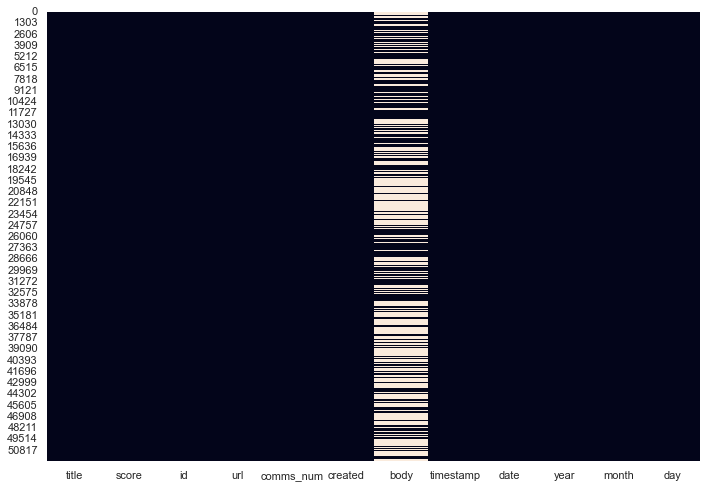

In [115]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(reddit_dataset.isnull(), cbar=False)
plt.show()

Podemos observar que la columna *body* tiene un gran número de registros nulos. Vamos a centrarnos en esta varaible apra identificar que esta sucediendo.

In [116]:
reddit_dataset[reddit_dataset['body'].isna()]

title  score      id  \
0      It's not about the money, it's about sending a...     55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...    110  l6uibd   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4      Not to distract from GME, just thought our AMC...     71  l6ufgy   
5                                    WE BREAKING THROUGH    405  l6uf7d   
...                                                  ...    ...     ...   
52102                                          Pro moves  22537  ode6ey   
52103  Root Inc. (ROOT) Just Entered My Buy Zone. Int...     83  odcvds   
52104          $3.2k -> $37.8k in 1 day on SPCE $45c FDs   1341  odc0nu   
52106  Everything I've learned about being on Wall St...   1011  od9xfn   
52108                      $53k TO $306K in just 2 days.   1190  od7008   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61          6   
1                        https://v.redd.it/ah50lyny62e61         23   
3      https://sec.report/Document/0001193125-21-019848/         74   
4                    https://i.redd.it/4h2sukb662e61.jpg        156   
5                    https://i.redd.it/2wef8tc062e61.png         84   
...                                                  ...        ...   
52102                https://i.redd.it/c39slsudv4971.jpg        352   
52103                https://i.redd.it/ufse5osed4971.png        130   
52104                https://i.redd.it/yij40o9u34971.png        305   
52106                    https://v.redd.it/dfkjjyjae3971         87   
52108                https://i.redd.it/k0pkc2m4i2971.png        237   

            created body            timestamp        date  year  month  day  
0      1.611863e+09  NaN  2021-01-28 21:37:41  2021-01-28  2021      1   28  
1      1.611862e+09  NaN  2021-01-28 21:32:10  2021-01-28  2021      1   28  
3      1.611862e+09  NaN  2021-01-28 21:28:57  2021-01-28  2021      1   28  
4      1.611862e+09  NaN  2021-01-28 21:26:56  2021-01-28  2021      1   28  
5      1.611862e+09  NaN  2021-01-28 21:26:30  2021-01-28  2021      1   28  
...             ...  ...                  ...         ...   ...    ...  ...  
52102  1.625377e+09  NaN  2021-07-04 08:39:57  2021-07-04  2021      7    4  
52103  1.625371e+09  NaN  2021-07-04 07:04:30  2021-07-04  2021      7    4  
52104  1.625368e+09  NaN  2021-07-04 06:06:08  2021-07-04  2021      7    4  
52106  1.625359e+09  NaN  2021-07-04 03:43:04  2021-07-04  2021      7    4  
52108  1.625349e+09  NaN  2021-07-04 00:42:06  2021-07-04  2021      7    4  

[27875 rows x 12 columns]

Seleccionamos una de las URL para ver si nos da más información.

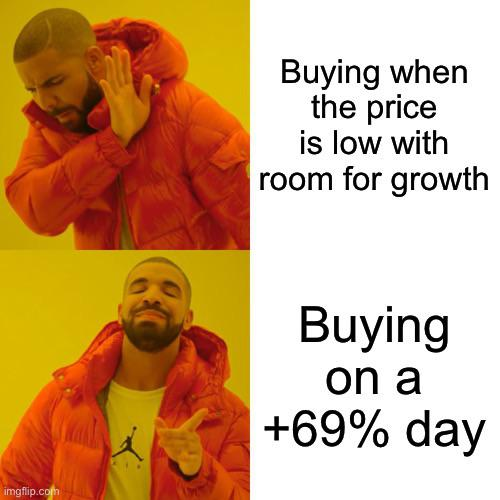

In [117]:
IPython.display.Image('https://i.redd.it/c39slsudv4971.jpg', width = 250)

A parte de imágenes, las URL de los registros que tienen la variable *body* nula, contienen videos, documentos y otros archivos multimedia. Esa es la razón por la que el cuerpo del post es nulo. Cuando realicemos el análisis sentimental del cuerpo del post deberemos eliminar estos registros. Pero no los descartaremos cuando analicemos el sentimiento de los titulos de los posts.

A continuación vamos a extraer información descriptiva de los datos. Con el parámetro *include = 'all'* especificamos que queremos información de todos los atributos del dataset, incluso si no son numéricos.

In [118]:
reddit_dataset.describe(include='all')

title          score      id  \
count   52111   52111.000000   52111   
unique  50983            NaN   52111   
top       AMC            NaN  l7jkhk   
freq       40            NaN       1   
mean      NaN    1392.054825     NaN   
std       NaN    8065.440508     NaN   
min       NaN       0.000000     NaN   
25%       NaN       1.000000     NaN   
50%       NaN      36.000000     NaN   
75%       NaN     205.000000     NaN   
max       NaN  348241.000000     NaN   

                                                   url     comms_num  \
count                                            52111  52111.000000   
unique                                           52096           NaN   
top     https://magic.freetrade.io/join/jamie/13edb513           NaN   
freq                                                11           NaN   
mean                                               NaN    258.724550   
std                                                NaN   2540.474545   
min                                                NaN      0.000000   
25%                                                NaN      3.000000   
50%                                                NaN     17.000000   
75%                                                NaN     58.000000   
max                                                NaN  93268.000000   

             created                                               body  \
count   5.211100e+04                                              24236   
unique           NaN                                              23702   
top              NaN  Your daily trading discussion thread. Please k...   
freq             NaN                                                 74   
mean    1.614303e+09                                                NaN   
std     3.733101e+06                                                NaN   
min     1.601340e+09                                                NaN   
25%     1.611882e+09                                                NaN   
50%     1.612479e+09                                                NaN   
75%     1.615066e+09                                                NaN   
max     1.626408e+09                                                NaN   

                  timestamp        date          year         month  \
count                 52111       52111  52111.000000  52111.000000   
unique                42384         158           NaN           NaN   
top     2021-01-29 01:03:59  2021-01-29           NaN           NaN   
freq                     14       15694           NaN           NaN   
mean                    NaN         NaN   2020.999981      2.296866   
std                     NaN         NaN      0.004381      1.534253   
min                     NaN         NaN   2020.000000      1.000000   
25%                     NaN         NaN   2021.000000      1.000000   
50%                     NaN         NaN   2021.000000      2.000000   
75%                     NaN         NaN   2021.000000      3.000000   
max                     NaN         NaN   2021.000000      9.000000   

                 day  
count   52111.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean       17.674694  
std        11.042699  
min         1.000000  
25%         6.000000  
50%        19.000000  
75%        29.000000  
max        31.000000

In [119]:
reddit_dataset.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  \
0                                                NaN  2021-01-28 21:37:41   
1                                                NaN  2021-01-28 21:32:10   
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35   
3                                                NaN  2021-01-28 21:28:57   
4                                                NaN  2021-01-28 21:26:56   

         date  year  month  day  
0  2021-01-28  2021      1   28  
1  2021-01-28  2021      1   28  
2  2021-01-28  2021      1   28  
3  2021-01-28  2021      1   28  
4  2021-01-28  2021      1   28

Vamos a explorar cual es la cantidad de posts que se han realizado en función de la fecha.

In [120]:
posts_fecha = reddit_dataset.groupby(['date']).size().reset_index(name='counts')

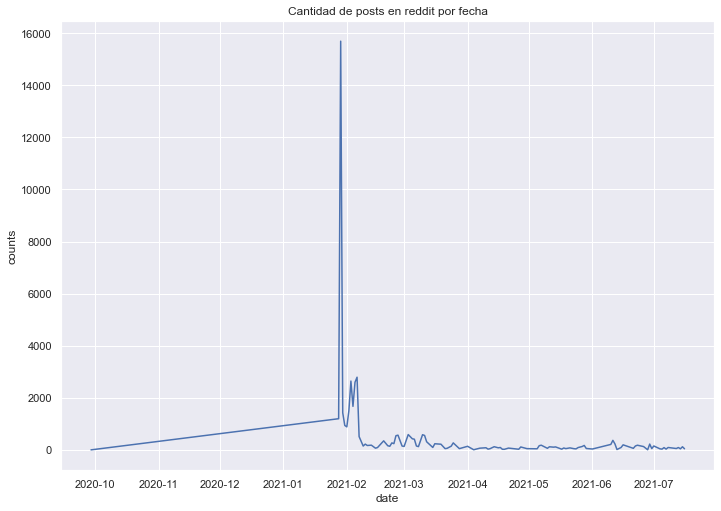

In [121]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(data=posts_fecha, x='date', y='counts').set_title('Cantidad de posts en reddit por fecha')

plt.show()

Vamos a explorar la puntuación media recibida en los posts en función de la fecha.

In [122]:
#score_fecha = reddit_dataset.groupby(['date']).size().reset_index(name='counts')

score_fecha = reddit_dataset[['score','date']].groupby(['date']).mean().reset_index()

score_fecha

date        score
0    2020-09-29     4.000000
1    2021-01-28   960.609023
2    2021-01-29   408.457309
3    2021-01-30  4618.594101
4    2021-01-31  5230.513312
..          ...          ...
153  2021-07-12   713.754717
154  2021-07-13   779.956044
155  2021-07-14  1263.268293
156  2021-07-15   725.500000
157  2021-07-16    65.162791

[158 rows x 2 columns]

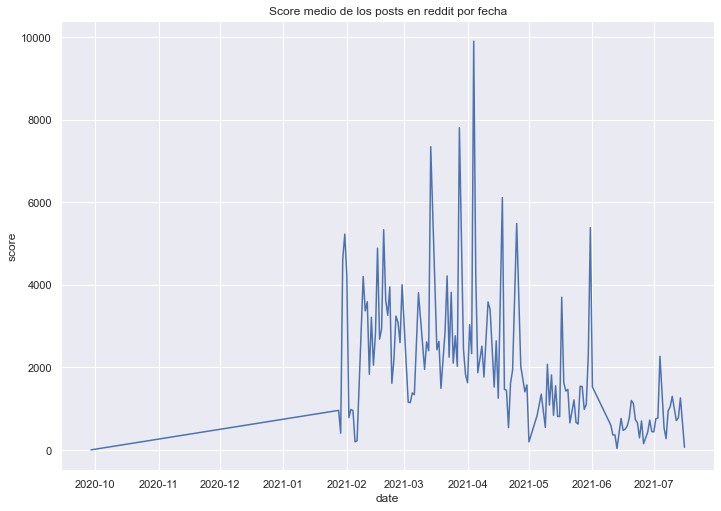

In [123]:
sns.lineplot(data=score_fecha, x='date', y='score').set_title('Score medio de los posts en reddit por fecha')

plt.show()

Vamos a explorar si la longitud del titulo o del cuerpo de los posts tienen relación con la puntuación de estos.

In [124]:
reddit_dataset.head(3)

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   

                                                body            timestamp  \
0                                                NaN  2021-01-28 21:37:41   
1                                                NaN  2021-01-28 21:32:10   
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35   

         date  year  month  day  
0  2021-01-28  2021      1   28  
1  2021-01-28  2021      1   28  
2  2021-01-28  2021      1   28

In [125]:
score_length=pd.DataFrame()
score_length['score'] = reddit_dataset['score']
score_length['title_len'] = pd.DataFrame(reddit_dataset['title'].str.len())

score_length['body_len'] = pd.DataFrame(reddit_dataset['body'].str.len())
score_length['comms_num'] = reddit_dataset['comms_num']

score_length

score  title_len  body_len  comms_num
0         55         59       NaN          6
1        110         80       NaN         23
2          0         15    1319.0         47
3         29         75       NaN         74
4         71         79       NaN        156
...      ...        ...       ...        ...
52106   1011         59       NaN         87
52107    510         54    2169.0        288
52108   1190         29       NaN        237
52109     74         44     994.0        194
52110     19         60    1010.0         64

[52111 rows x 4 columns]

Reemplazamos los registros con valor *nan* en la columna *body_len* por 0.

In [126]:
score_length.fillna(0)

score  title_len  body_len  comms_num
0         55         59       0.0          6
1        110         80       0.0         23
2          0         15    1319.0         47
3         29         75       0.0         74
4         71         79       0.0        156
...      ...        ...       ...        ...
52106   1011         59       0.0         87
52107    510         54    2169.0        288
52108   1190         29       0.0        237
52109     74         44     994.0        194
52110     19         60    1010.0         64

[52111 rows x 4 columns]

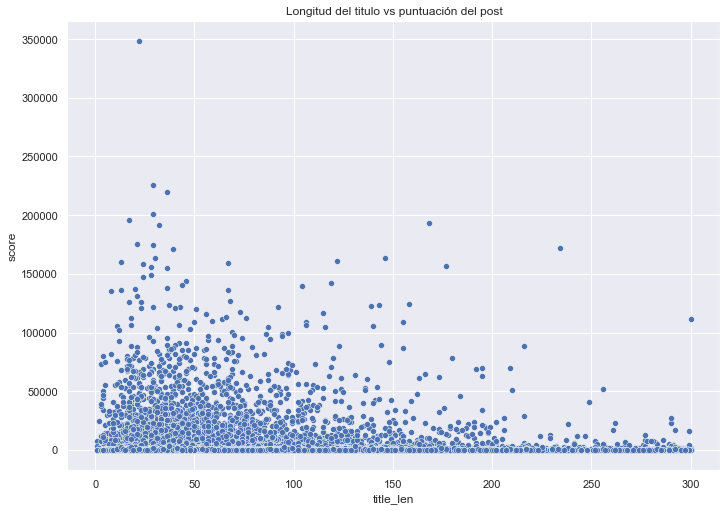

In [127]:
sns.scatterplot(data=score_length, x='title_len', y='score').set_title('Longitud del titulo vs puntuación del post')

plt.show()

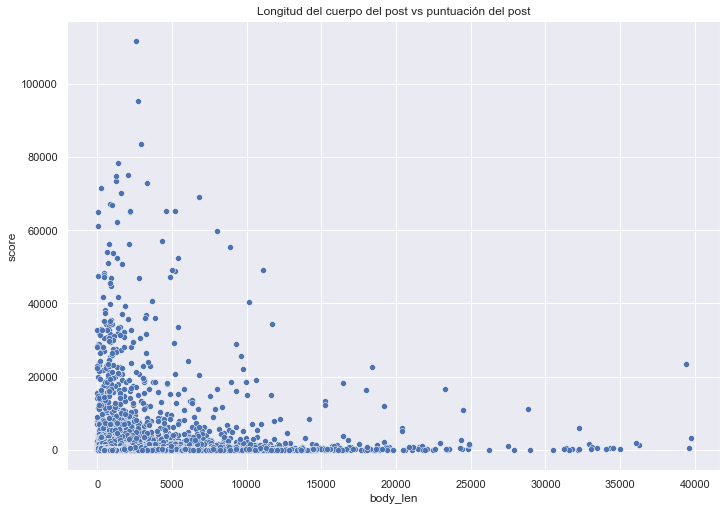

In [128]:
sns.scatterplot(data=score_length, x='body_len', y='score').set_title('Longitud del cuerpo del post vs puntuación del post')

plt.show()

Con el mismo dataset que hemos generado vamos a explorar si la puntuación del post tiene relación con el número de comentarios. 

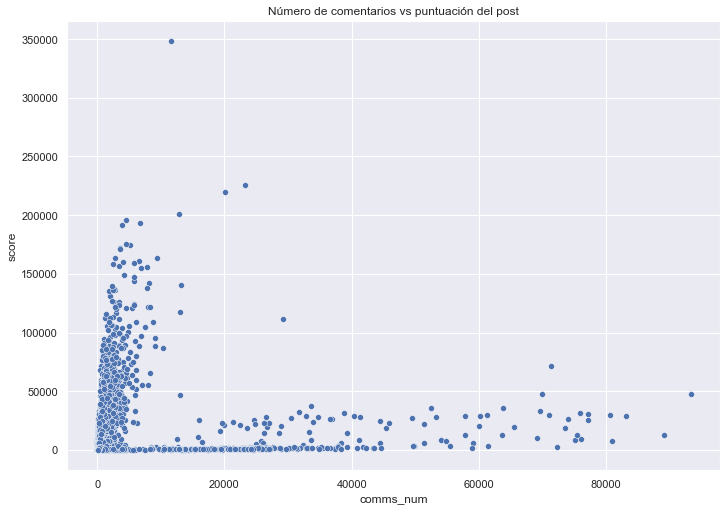

In [129]:
sns.scatterplot(data=score_length, x='comms_num', y='score').set_title('Número de comentarios vs puntuación del post')

plt.show()

También vamos a estudiar la distribución de comentarios de los posts

C:\Users\david\Anaconda3\envs\Env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


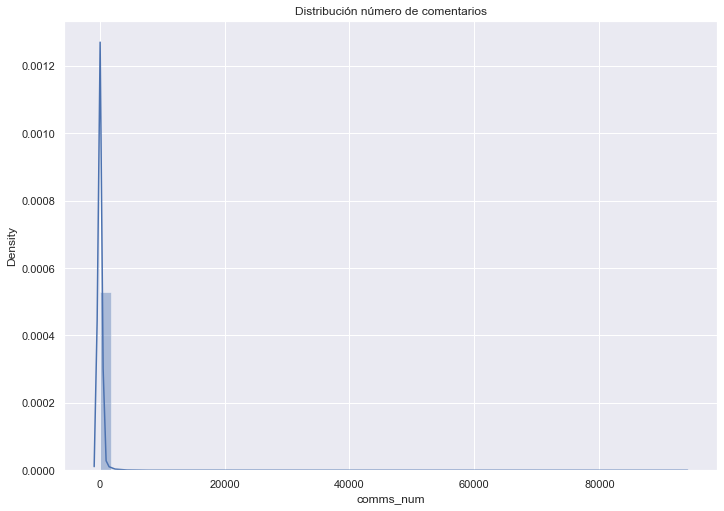

In [130]:
sns.distplot(score_length['comms_num']).set_title('Distribución número de comentarios')

plt.show()

También vamos a estudiar la distribución de las puntuaciones de los posts

C:\Users\david\Anaconda3\envs\Env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


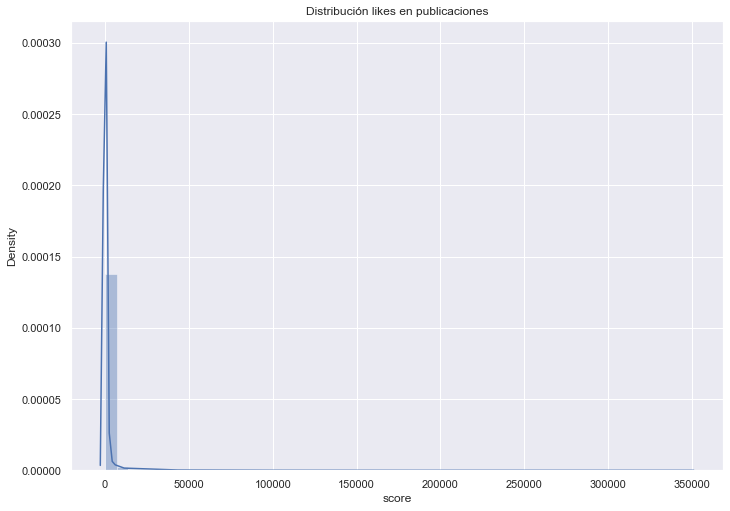

In [132]:
sns.distplot(score_length['score']).set_title('Distribución likes en publicaciones')

plt.show()

### 4.2. EDA precio GME <a class="anchor" id="section_4_2"></a>

In [27]:
gme_dataset.head(5)

Date   Close   Volume    Open      High       Low   week_day
0  08/20/2021  159.30  1154858  153.80  160.0900  153.2400     Friday
1  08/19/2021  152.90  1196548  156.77  157.9899  150.7800   Thursday
2  08/18/2021  157.05  1411842  163.25  165.6000  156.7500  Wednesday
3  08/17/2021  163.55  1215938  161.19  169.4800  161.1000    Tuesday
4  08/16/2021  163.93  1574877  161.00  169.8799  159.1601     Monday

In [28]:
gme_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      252 non-null    object 
 1   Close     252 non-null    float64
 2   Volume    252 non-null    int64  
 3   Open      252 non-null    float64
 4   High      252 non-null    float64
 5   Low       252 non-null    float64
 6   week_day  252 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 13.9+ KB


Vamos a convertir el tipo de datos de la columna *date* a tipo *datetime*, esto nos facilitará tratar con este campo posteriormente.

In [29]:
gme_dataset['Date'] = pd.to_datetime(gme_dataset['Date'], format='%m/%d/%Y')

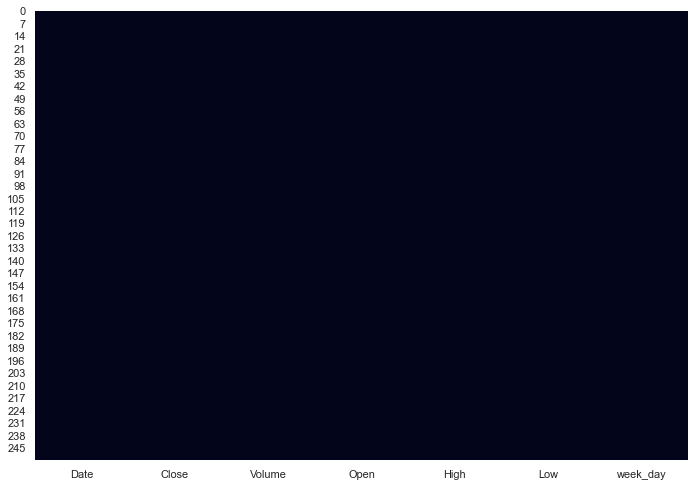

In [30]:
sns.heatmap(gme_dataset.isnull(), cbar=False)
plt.show()

Podemos observar que el dataset no contiene valores nulos.

Vamos a detallar más la información de cada una de las variables para hacernos una mejor idea de estas.

In [31]:
gme_dataset.describe(include='all')

C:\Users\david\AppData\Local\Temp/ipykernel_19644/1064862866.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  gme_dataset.describe(include='all')


Date       Close        Volume        Open        High  \
count                   252  252.000000  2.520000e+02  252.000000  252.000000   
unique                  252         NaN           NaN         NaN         NaN   
top     2021-03-03 00:00:00         NaN           NaN         NaN         NaN   
freq                      1         NaN           NaN         NaN         NaN   
first   2020-08-21 00:00:00         NaN           NaN         NaN         NaN   
last    2021-08-20 00:00:00         NaN           NaN         NaN         NaN   
mean                    NaN  105.981032  1.765364e+07  107.189393  115.542853   
std                     NaN   89.901321  2.841126e+07   92.004999  100.110119   
min                     NaN    4.870000  9.454280e+05    4.600000    5.130000   
25%                     NaN   13.790000  4.344478e+06   13.682500   14.293750   
50%                     NaN  119.260000  7.870080e+06  119.985000  146.623500   
75%                     NaN  180.135000  1.627957e+07  179.962500  187.547500   
max                     NaN  347.510000  1.971579e+08  379.710000  483.000000   

               Low week_day  
count   252.000000      252  
unique         NaN        5  
top            NaN  Tuesday  
freq           NaN       52  
first          NaN      NaN  
last           NaN      NaN  
mean     98.646604      NaN  
std      83.534723      NaN  
min       4.560000      NaN  
25%      13.072500      NaN  
50%     100.485000      NaN  
75%     171.062500      NaN  
max     291.510000      NaN

Vamos a explorar los precios de apertura en función de la fecha.

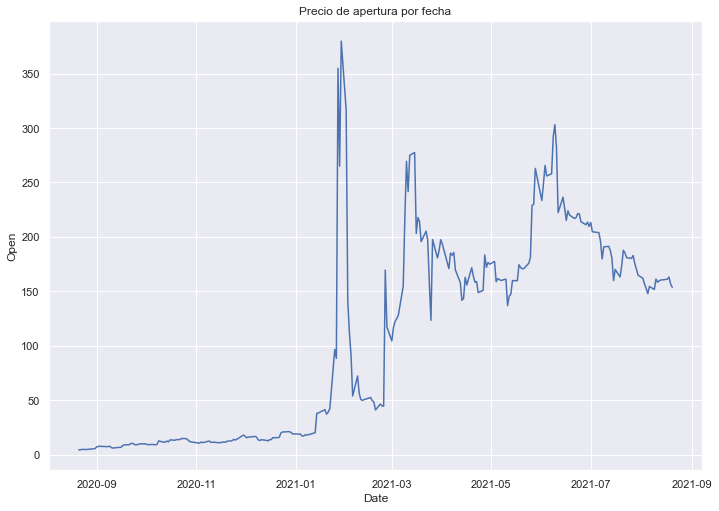

In [32]:
sns.lineplot(data=gme_dataset, x='Date', y='Open').set_title('Precio de apertura por fecha')

plt.show()

Pero el precio de apertura únicamente no nos aporta mucho valor. En economía se suele utilizar muy comúnmente un tipo de gráficos llamado *velas japonesas*, que permiten representar en un formato muy compacto el precio de apertura de la acción, el precio de cierre, el precio máximo que ha alcanzado la acción y el precio mínimo. De esta manera maximizamos el valor que el gráfico nos puede ofrecer, incluso representando si la acción ha tenido un precio de cierre inferior o superior al precio de apertura mediante colores. 

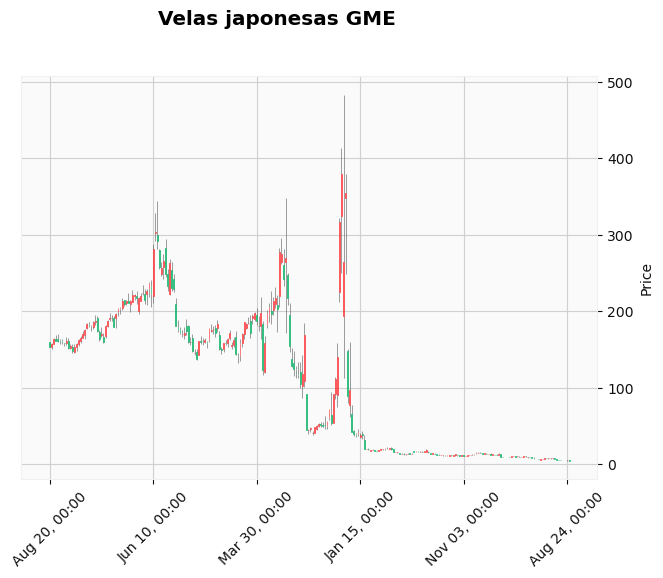

In [33]:
gme_dataset_candles = gme_dataset.copy()
gme_dataset_candles = gme_dataset_candles.set_index('Date')

mpf.plot(data = gme_dataset_candles,
         type = 'candle',
         style = 'yahoo',
         title = 'Velas japonesas GME'
)

El orden de los registros es inverso al tiempo por lo que debemos cambiar el orden de todos los registros del dataset. LEl primer registro será el último y el último registro sera el primero.

In [34]:
gme_dataset_candles = gme_dataset_candles.iloc[::-1]

gme_dataset_candles

Close    Volume    Open      High       Low   week_day
Date                                                               
2020-08-21    5.03  10642590    4.60    5.6000    4.5950     Friday
2020-08-24    4.87   4585366    5.10    5.1300    4.5600     Monday
2020-08-25    4.98   2998678    4.88    5.2500    4.8800    Tuesday
2020-08-26    5.11   2779664    4.97    5.2200    4.9199  Wednesday
2020-08-27    5.25   3384658    5.11    5.3799    5.0200   Thursday
...            ...       ...     ...       ...       ...        ...
2021-08-16  163.93   1574877  161.00  169.8799  159.1601     Monday
2021-08-17  163.55   1215938  161.19  169.4800  161.1000    Tuesday
2021-08-18  157.05   1411842  163.25  165.6000  156.7500  Wednesday
2021-08-19  152.90   1196548  156.77  157.9899  150.7800   Thursday
2021-08-20  159.30   1154858  153.80  160.0900  153.2400     Friday

[252 rows x 6 columns]

Volvemos a generar el gráfico de velas japonesas.

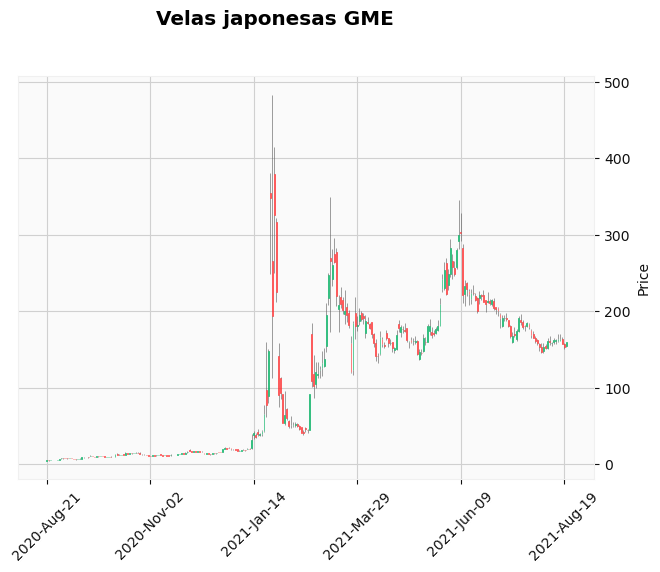

In [35]:
mpf.plot(data = gme_dataset_candles,
         type = 'candle',
         style = 'yahoo',
         title = 'Velas japonesas GME'
)

## 5. Análisis sentimientos <a class="anchor" id="cap5"></a>

### 5.1. Clasificación sentimientos títulos <a class="anchor" id="section_5_1"></a>

#### 5.1.1. Modelo BERT <a class="anchor" id="section_5_1_1"></a>

In [36]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model_BERT = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Vamos a analizar un título individualmente. 

In [37]:
reddit_dataset['title'].iloc[1]

'Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts'

El primer paso es tokenizar el texto que queramos analizar. El codificador nos devuelve una lista de la codificación del texto que le pasamos por parámetro.

In [38]:
tokens = tokenizer.encode_plus(
    reddit_dataset['title'].iloc[1],
    add_special_tokens = True,
    return_tensors = 'pt'
)

tokens['input_ids'][0]

tensor([  101, 33508, 12156, 13064, 39241, 20782, 10103, 18627, 55759, 41055,
        10139, 12052, 33876, 12972, 10107,   102])

Con el texto codificado podemos alimentar el modelo. El modelo nos devuelve otra lista, logits, con 5 valores que representan la probabilidad de que el texto que estamos analizando tenga un sentimiento negativo - negativo/neutro - neutro - positivo/neutro - positivo, respectivamente. El valor máximo de la la lista nos indicará cual es el sentimiento predominante del texto analizado.

In [39]:
result = model_BERT(tokens['input_ids'])

result

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.8411,  0.8529,  0.3576, -0.5118, -1.3356]],
       grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

En el ejemplo podemos ver que para el texto analizado el modelo nos devuelve un sentimiento predominante negativo/neutro.

Para poder extraer el sentimiento predominante de todos los títulos vamos a crear una función que ejecutaremos para cada registro del dataset. La función realizará cada unos de los pasos anteriormente explicados.

In [40]:
def BERT_sentiment_score(texto):
        tokens = tokenizer.encode_plus(texto,add_special_tokens = True,return_tensors = 'pt')
        result = model_BERT(tokens['input_ids'])
        return int(torch.argmax(result.logits))+1 #De los 5 resultados ,que representan las probabilidades del sentimiento del texto, que nos devuelve el modelo nos quedamos con el max

Aplicamos la función para calcular el sentimiento de los títulos con el modelo BERT y lo almacenamos en una nueva variable en el dataset. Para facilitar el desarrollo, y no calcular constantemente el sentimiento de los títulos, una vez generado el sentimiento de los títulos se ha exportado a csv el dataset. Si el csv no se encuentra disponible, sería el caso de una ejecución inicial, se calcularía el sentimiento de los títulos del dataset.

In [41]:
if os.path.isfile('reddit_dataset_BERT_score_title.csv'):
    reddit_dataset = pd.read_csv('reddit_dataset_BERT_score_title.csv', sep=';')
else:
    reddit_dataset['BERT_score_title'] = reddit_dataset['title'].apply(lambda x: BERT_sentiment_score(x[:512]))
    reddit_dataset.to_csv(path_or_buf = './reddit_dataset_BERT_score_title.csv', index=False) # Guardamos el estado actual del dataset en formato CVS para no tener qu replicarlo en cada ejecucion
    
reddit_dataset

title score      id  \
0      It's not about the money, it's about sending a...    55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...   110  l6uibd   
2                                        Exit the system     0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...    29  l6ugk6   
4      Not to distract from GME, just thought our AMC...    71  l6ufgy   
...                                                  ...   ...     ...   
52135  Everything I've learned about being on Wall St...  1011  od9xfn   
52136  I Accidentally YOLOed Half My Portfolio After ...   510  od97ek   
52137                      $53k TO $306K in just 2 days.  1190  od7008   
52138       Average Annual Return on Investments for WSB    74  od77kx   
52139  Genuine question about hypothetical stock shor...    19  od75w3   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61        6.0   
1                        https://v.redd.it/ah50lyny62e61       23.0   
2      https://www.reddit.com/r/wallstreetbets/commen...       47.0   
3      https://sec.report/Document/0001193125-21-019848/       74.0   
4                    https://i.redd.it/4h2sukb662e61.jpg      156.0   
...                                                  ...        ...   
52135                    https://v.redd.it/dfkjjyjae3971       87.0   
52136  https://www.reddit.com/r/wallstreetbets/commen...      288.0   
52137                https://i.redd.it/k0pkc2m4i2971.png      237.0   
52138  https://www.reddit.com/r/wallstreetbets/commen...      194.0   
52139  https://www.reddit.com/r/wallstreetbets/commen...       64.0   

            created                                               body  \
0      1.611863e+10                                                NaN   
1      1.611862e+10                                                NaN   
2      1.611862e+10  The CEO of NASDAQ pushed to halt trading “to g...   
3      1.611862e+10                                                NaN   
4      1.611862e+10                                                NaN   
...             ...                                                ...   
52135  1.625359e+10                                                NaN   
52136  1.625357e+10  tl;dr at bottom\n\nSo after using DD from [u/C...   
52137  1.625349e+10                                                NaN   
52138  1.625349e+10  I was having a discussion with my friends abou...   
52139  1.625349e+10  So I want to start this off by saying you prob...   

              timestamp        date    year  month   day  BERT_score_title  
0      28/01/2021 21:37  28/01/2021  2021.0    1.0  28.0               1.0  
1      28/01/2021 21:32  28/01/2021  2021.0    1.0  28.0               2.0  
2      28/01/2021 21:30  28/01/2021  2021.0    1.0  28.0               1.0  
3      28/01/2021 21:28  28/01/2021  2021.0    1.0  28.0               5.0  
4      28/01/2021 21:26  28/01/2021  2021.0    1.0  28.0               3.0  
...                 ...         ...     ...    ...   ...               ...  
52135   04/07/2021 3:43  04/07/2021  2021.0    7.0   4.0               5.0  
52136   04/07/2021 2:55  04/07/2021  2021.0    7.0   4.0               1.0  
52137   04/07/2021 0:42  04/07/2021  2021.0    7.0   4.0               1.0  
52138   04/07/2021 0:54  04/07/2021  2021.0    7.0   4.0               3.0  
52139   04/07/2021 0:51  04/07/2021  2021.0    7.0   4.0               4.0  

[52140 rows x 13 columns]

In [42]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### 5.1.2. Librería NLTK <a class="anchor" id="section_5_1_2"></a>

In [43]:
sid = SIA()

test_nltk_title = reddit_dataset[['title', 'id']].copy()

test_nltk_title['title'] = test_nltk_title.title.astype(str)

In [44]:
#Remove handlers
test_nltk_title.title = test_nltk_title.title.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
test_nltk_title.title = test_nltk_title.title.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
test_nltk_title.title = test_nltk_title.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
test_nltk_title.title = test_nltk_title.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
test_nltk_title.title = test_nltk_title.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

Separamos en columnas diferentes cada uno de los sentimientos estimados para cada título.

Añadimos un termino a cada sentimiento para evitar la situación en la que uno de ellos es igual a cero, tener un valor mínimo nos previene de tener que aplicar una transformación logarítmica en valores cero. 

In [45]:
test_nltk_title['sentiments'] = test_nltk_title['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
test_nltk_title['Positivo'] = test_nltk_title['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
test_nltk_title['Neutral'] = test_nltk_title['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
test_nltk_title['Negativo'] = test_nltk_title['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

test_nltk_title

title      id  \
0           Itnot about the money itabout sendingmessage  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...  l6uibd   
2                                        Exit the system  l6uhhn   
3      NEW SEC FILING FOR GME CAN SOMEONE LESS RETARD...  l6ugk6   
4      Not to distract from GME just thought our AMC ...  l6ufgy   
...                                                  ...     ...   
52135  Everythingve learned about being on Wall Stree...  od9xfn   
52136  I Accidentally YOLOed Half My Portfolio After ...  od97ek   
52137                         53k TO 306K in just 2 days  od7008   
52138       Average Annual Return on Investments for WSB  od77kx   
52139  Genuine question about hypothetical stock shor...  od75w3   

                                              sentiments  Positivo   Neutral  \
0      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000001  1.000001   
1      {'neg': 0.272, 'neu': 0.728, 'pos': 0.0, 'comp...  0.000001  0.728001   
2      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000001  1.000001   
3      {'neg': 0.204, 'neu': 0.658, 'pos': 0.138, 'co...  0.138001  0.658001   
4      {'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp...  0.119001  0.881001   
...                                                  ...       ...       ...   
52135  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000001  1.000001   
52136  {'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp...  0.000001  0.745001   
52137  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000001  1.000001   
52138  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000001  1.000001   
52139  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000001  1.000001   

       Negativo  
0      0.000001  
1      0.272001  
2      0.000001  
3      0.204001  
4      0.000001  
...         ...  
52135  0.000001  
52136  0.255001  
52137  0.000001  
52138  0.000001  
52139  0.000001  

[52140 rows x 6 columns]

Creamos una función para identificar el sentimiento predomeinante de los títulos y lo almacenamos en una nueva columna. El resultado se codifica con un valor numérico que responde a: sentimiento negativo = 1, sentimiento neutral = 3, sentimiento positivo = 5.

In [46]:
def nltk_sent_predominante(x):       
    if x['Positivo'] > x['Neutral'] and x['Positivo'] > x['Negativo']:
        return 5 # Codificación de sentimiento predominante Positivo
    elif x['Negativo'] > x['Positivo'] and x['Negativo'] > x['Neutral']: 
        return 1 # Codificación de sentimiento predominante Negativo
    else:
        return 3 # Codificación de sentimiento predominante Neutro

test_nltk_title['nltk_score_title'] = test_nltk_title[['Positivo','Neutral', 'Negativo']].apply(nltk_sent_predominante, axis=1)

Unimos el dataset con el scoring de los títulos obtenidos con la librería *NLTK* al dataset *maestro*.

In [47]:
reddit_dataset = reddit_dataset.merge(
    test_nltk_title[['id','nltk_score_title']], 
    how ='left', 
    left_on = 'id', 
    right_on = 'id'
)

reddit_dataset

title score      id  \
0      It's not about the money, it's about sending a...    55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...   110  l6uibd   
2                                        Exit the system     0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...    29  l6ugk6   
4      Not to distract from GME, just thought our AMC...    71  l6ufgy   
...                                                  ...   ...     ...   
52839  Everything I've learned about being on Wall St...  1011  od9xfn   
52840  I Accidentally YOLOed Half My Portfolio After ...   510  od97ek   
52841                      $53k TO $306K in just 2 days.  1190  od7008   
52842       Average Annual Return on Investments for WSB    74  od77kx   
52843  Genuine question about hypothetical stock shor...    19  od75w3   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61        6.0   
1                        https://v.redd.it/ah50lyny62e61       23.0   
2      https://www.reddit.com/r/wallstreetbets/commen...       47.0   
3      https://sec.report/Document/0001193125-21-019848/       74.0   
4                    https://i.redd.it/4h2sukb662e61.jpg      156.0   
...                                                  ...        ...   
52839                    https://v.redd.it/dfkjjyjae3971       87.0   
52840  https://www.reddit.com/r/wallstreetbets/commen...      288.0   
52841                https://i.redd.it/k0pkc2m4i2971.png      237.0   
52842  https://www.reddit.com/r/wallstreetbets/commen...      194.0   
52843  https://www.reddit.com/r/wallstreetbets/commen...       64.0   

            created                                               body  \
0      1.611863e+10                                                NaN   
1      1.611862e+10                                                NaN   
2      1.611862e+10  The CEO of NASDAQ pushed to halt trading “to g...   
3      1.611862e+10                                                NaN   
4      1.611862e+10                                                NaN   
...             ...                                                ...   
52839  1.625359e+10                                                NaN   
52840  1.625357e+10  tl;dr at bottom\n\nSo after using DD from [u/C...   
52841  1.625349e+10                                                NaN   
52842  1.625349e+10  I was having a discussion with my friends abou...   
52843  1.625349e+10  So I want to start this off by saying you prob...   

              timestamp        date    year  month   day  BERT_score_title  \
0      28/01/2021 21:37  28/01/2021  2021.0    1.0  28.0               1.0   
1      28/01/2021 21:32  28/01/2021  2021.0    1.0  28.0               2.0   
2      28/01/2021 21:30  28/01/2021  2021.0    1.0  28.0               1.0   
3      28/01/2021 21:28  28/01/2021  2021.0    1.0  28.0               5.0   
4      28/01/2021 21:26  28/01/2021  2021.0    1.0  28.0               3.0   
...                 ...         ...     ...    ...   ...               ...   
52839   04/07/2021 3:43  04/07/2021  2021.0    7.0   4.0               5.0   
52840   04/07/2021 2:55  04/07/2021  2021.0    7.0   4.0               1.0   
52841   04/07/2021 0:42  04/07/2021  2021.0    7.0   4.0               1.0   
52842   04/07/2021 0:54  04/07/2021  2021.0    7.0   4.0               3.0   
52843   04/07/2021 0:51  04/07/2021  2021.0    7.0   4.0               4.0   

       nltk_score_title  
0                     3  
1                     3  
2                     3  
3                     3  
4                     3  
...                 ...  
52839                 3  
52840                 3  
52841                 3  
52842                 3  
52843                 3  

[52844 rows x 14 columns]

### 5.2. Clasificación sentimientos posts <a class="anchor" id="section_5_2"></a>

#### 5.2.1 Modelo BERT <a class="anchor" id="section_5_2_1"></a>

De una manera similar aplicamos la función para calcular el sentimiento del cuerpo de los posts con el modelo BERT y lo almacenamos en una nueva variable en el dataset. Para facilitar el desarrollo, y no calcular constantemente el sentimiento de los posts, una vez generado el sentimiento de los posts se ha exportado a csv el dataset. Si el csv no se encuentra disponible, sería el caso de una ejecución inicial, se calcularía el sentimiento de los posts del dataset.

In [48]:
if os.path.isfile('test.csv'):
    BERT_score_body = pd.read_csv('test.csv')
    BERT_score_body = BERT_score_body.rename(columns={'Unnamed: 0': 'Indice'})
else:
    BERT_score_body = reddit_dataset.dropna(subset = ["body"])['body'].apply(lambda x: BERT_sentiment_score(x[:512]))
    BERT_score_body.to_csv(path_or_buf = './test.csv', index=True)
    
BERT_score_body

Indice  body
0           2     1
1           6     1
2           7     2
3          10     5
4          12     1
...       ...   ...
24231   52101     1
24232   52105     1
24233   52107     2
24234   52109     2
24235   52110     2

[24236 rows x 2 columns]

In [49]:
reddit_dataset = reddit_dataset.merge(
    BERT_score_body, 
    how ='left', 
    left_index = True, 
    right_on = 'Indice'
).reset_index(drop=True)

In [50]:
reddit_dataset

title score      id  \
0      It's not about the money, it's about sending a...    55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...   110  l6uibd   
2                                        Exit the system     0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...    29  l6ugk6   
4      Not to distract from GME, just thought our AMC...    71  l6ufgy   
...                                                  ...   ...     ...   
52839  Everything I've learned about being on Wall St...  1011  od9xfn   
52840  I Accidentally YOLOed Half My Portfolio After ...   510  od97ek   
52841                      $53k TO $306K in just 2 days.  1190  od7008   
52842       Average Annual Return on Investments for WSB    74  od77kx   
52843  Genuine question about hypothetical stock shor...    19  od75w3   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61        6.0   
1                        https://v.redd.it/ah50lyny62e61       23.0   
2      https://www.reddit.com/r/wallstreetbets/commen...       47.0   
3      https://sec.report/Document/0001193125-21-019848/       74.0   
4                    https://i.redd.it/4h2sukb662e61.jpg      156.0   
...                                                  ...        ...   
52839                    https://v.redd.it/dfkjjyjae3971       87.0   
52840  https://www.reddit.com/r/wallstreetbets/commen...      288.0   
52841                https://i.redd.it/k0pkc2m4i2971.png      237.0   
52842  https://www.reddit.com/r/wallstreetbets/commen...      194.0   
52843  https://www.reddit.com/r/wallstreetbets/commen...       64.0   

            created                                             body_x  \
0      1.611863e+10                                                NaN   
1      1.611862e+10                                                NaN   
2      1.611862e+10  The CEO of NASDAQ pushed to halt trading “to g...   
3      1.611862e+10                                                NaN   
4      1.611862e+10                                                NaN   
...             ...                                                ...   
52839  1.625359e+10                                                NaN   
52840  1.625357e+10  tl;dr at bottom\n\nSo after using DD from [u/C...   
52841  1.625349e+10                                                NaN   
52842  1.625349e+10  I was having a discussion with my friends abou...   
52843  1.625349e+10  So I want to start this off by saying you prob...   

              timestamp        date    year  month   day  BERT_score_title  \
0      28/01/2021 21:37  28/01/2021  2021.0    1.0  28.0               1.0   
1      28/01/2021 21:32  28/01/2021  2021.0    1.0  28.0               2.0   
2      28/01/2021 21:30  28/01/2021  2021.0    1.0  28.0               1.0   
3      28/01/2021 21:28  28/01/2021  2021.0    1.0  28.0               5.0   
4      28/01/2021 21:26  28/01/2021  2021.0    1.0  28.0               3.0   
...                 ...         ...     ...    ...   ...               ...   
52839   04/07/2021 3:43  04/07/2021  2021.0    7.0   4.0               5.0   
52840   04/07/2021 2:55  04/07/2021  2021.0    7.0   4.0               1.0   
52841   04/07/2021 0:42  04/07/2021  2021.0    7.0   4.0               1.0   
52842   04/07/2021 0:54  04/07/2021  2021.0    7.0   4.0               3.0   
52843   04/07/2021 0:51  04/07/2021  2021.0    7.0   4.0               4.0   

       nltk_score_title  Indice  body_y  
0                     3       0     NaN  
1                     3       1     NaN  
2                     3       2     1.0  
3                     3       3     NaN  
4                     3       4     NaN  
...                 ...     ...     ...  
52839                 3   52839     NaN  
52840                 3   52840     NaN  
52841                 3   52841     NaN  
52842                 3   52842     NaN  
52843                

In [51]:
reddit_dataset = reddit_dataset.rename(columns = {'body_x': 'body', 'body_y': 'BERT_score_body'}).drop(columns=['Indice'])

In [52]:
reddit_dataset.head()

title score      id  \
0  It's not about the money, it's about sending a...    55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...   110  l6uibd   
2                                    Exit the system     0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...    29  l6ugk6   
4  Not to distract from GME, just thought our AMC...    71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61        6.0  1.611863e+10   
1                    https://v.redd.it/ah50lyny62e61       23.0  1.611862e+10   
2  https://www.reddit.com/r/wallstreetbets/commen...       47.0  1.611862e+10   
3  https://sec.report/Document/0001193125-21-019848/       74.0  1.611862e+10   
4                https://i.redd.it/4h2sukb662e61.jpg      156.0  1.611862e+10   

                                                body         timestamp  \
0                                                NaN  28/01/2021 21:37   
1                                                NaN  28/01/2021 21:32   
2  The CEO of NASDAQ pushed to halt trading “to g...  28/01/2021 21:30   
3                                                NaN  28/01/2021 21:28   
4                                                NaN  28/01/2021 21:26   

         date    year  month   day  BERT_score_title  nltk_score_title  \
0  28/01/2021  2021.0    1.0  28.0               1.0                 3   
1  28/01/2021  2021.0    1.0  28.0               2.0                 3   
2  28/01/2021  2021.0    1.0  28.0               1.0                 3   
3  28/01/2021  2021.0    1.0  28.0               5.0                 3   
4  28/01/2021  2021.0    1.0  28.0               3.0                 3   

   BERT_score_body  
0              NaN  
1              NaN  
2              1.0  
3              NaN  
4              NaN

#### 5.2.2 Librería NLTK <a class="anchor" id="section_5_2_2"></a>

In [53]:
nltk_body = reddit_dataset[['body', 'id']].copy()

nltk_body = nltk_body.dropna()

nltk_body['body'] = nltk_body.body.astype(str)

In [54]:
#Remove handlers
nltk_body.body = nltk_body.body.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
nltk_body.body = nltk_body.body.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
nltk_body.body = nltk_body.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
nltk_body.body = nltk_body.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
nltk_body.body = nltk_body.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [55]:
nltk_body['sentiments'] = nltk_body['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
nltk_body['Positivo'] = nltk_body['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
nltk_body['Neutral'] = nltk_body['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
nltk_body['Negativo'] = nltk_body['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

nltk_body

body      id  \
2      The CEO of NASDAQ pushed to halt trading to gi...  l6uhhn   
6      Hedgefund whales are spreading disinfo saying ...  l6uf6d   
7      Life isnfair My mother always told me that whe...  l6ub9l   
10     I believe right now is one of those rare oppor...  l6uao1   
12     You guys are champs GME who would have thought...  l6u9wu   
...                                                  ...     ...   
52834  Inductions User Cast Vote Votersinb4elonmusk C...  odgmug   
52838  Recently todaygas pipeline under the Gulf of M...  odb0ir   
52840  tl dr at bottom So after using DD fromCriand T...  od97ek   
52842  I was havingdiscussion with my friends about i...  od77kx   
52843  Sowant to start this off by saying you probabl...  od75w3   

                                              sentiments  Positivo   Neutral  \
2      {'neg': 0.044, 'neu': 0.9, 'pos': 0.055, 'comp...  0.055001  0.900001   
6      {'neg': 0.06, 'neu': 0.913, 'pos': 0.026, 'com...  0.026001  0.913001   
7      {'neg': 0.164, 'neu': 0.772, 'pos': 0.065, 'co...  0.065001  0.772001   
10     {'neg': 0.086, 'neu': 0.762, 'pos': 0.152, 'co...  0.152001  0.762001   
12     {'neg': 0.051, 'neu': 0.832, 'pos': 0.117, 'co...  0.117001  0.832001   
...                                                  ...       ...       ...   
52834  {'neg': 0.059, 'neu': 0.918, 'pos': 0.024, 'co...  0.024001  0.918001   
52838  {'neg': 0.089, 'neu': 0.807, 'pos': 0.104, 'co...  0.104001  0.807001   
52840  {'neg': 0.064, 'neu': 0.838, 'pos': 0.099, 'co...  0.099001  0.838001   
52842  {'neg': 0.055, 'neu': 0.83, 'pos': 0.115, 'com...  0.115001  0.830001   
52843  {'neg': 0.04, 'neu': 0.859, 'pos': 0.101, 'com...  0.101001  0.859001   

       Negativo  
2      0.044001  
6      0.060001  
7      0.164001  
10     0.086001  
12     0.051001  
...         ...  
52834  0.059001  
52838  0.089001  
52840  0.064001  
52842  0.055001  
52843  0.040001  

[24249 rows x 6 columns]

In [56]:
nltk_body['nltk_score_body'] = nltk_body[['Positivo','Neutral', 'Negativo']].apply(nltk_sent_predominante, axis=1)

In [57]:
reddit_dataset = reddit_dataset.merge(
    nltk_body[['id','nltk_score_body']], 
    how ='left', 
    left_on = 'id', 
    right_on = 'id'
)

reddit_dataset

title score      id  \
0      It's not about the money, it's about sending a...    55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...   110  l6uibd   
2                                        Exit the system     0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...    29  l6ugk6   
4      Not to distract from GME, just thought our AMC...    71  l6ufgy   
...                                                  ...   ...     ...   
52851  Everything I've learned about being on Wall St...  1011  od9xfn   
52852  I Accidentally YOLOed Half My Portfolio After ...   510  od97ek   
52853                      $53k TO $306K in just 2 days.  1190  od7008   
52854       Average Annual Return on Investments for WSB    74  od77kx   
52855  Genuine question about hypothetical stock shor...    19  od75w3   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61        6.0   
1                        https://v.redd.it/ah50lyny62e61       23.0   
2      https://www.reddit.com/r/wallstreetbets/commen...       47.0   
3      https://sec.report/Document/0001193125-21-019848/       74.0   
4                    https://i.redd.it/4h2sukb662e61.jpg      156.0   
...                                                  ...        ...   
52851                    https://v.redd.it/dfkjjyjae3971       87.0   
52852  https://www.reddit.com/r/wallstreetbets/commen...      288.0   
52853                https://i.redd.it/k0pkc2m4i2971.png      237.0   
52854  https://www.reddit.com/r/wallstreetbets/commen...      194.0   
52855  https://www.reddit.com/r/wallstreetbets/commen...       64.0   

            created                                               body  \
0      1.611863e+10                                                NaN   
1      1.611862e+10                                                NaN   
2      1.611862e+10  The CEO of NASDAQ pushed to halt trading “to g...   
3      1.611862e+10                                                NaN   
4      1.611862e+10                                                NaN   
...             ...                                                ...   
52851  1.625359e+10                                                NaN   
52852  1.625357e+10  tl;dr at bottom\n\nSo after using DD from [u/C...   
52853  1.625349e+10                                                NaN   
52854  1.625349e+10  I was having a discussion with my friends abou...   
52855  1.625349e+10  So I want to start this off by saying you prob...   

              timestamp        date    year  month   day  BERT_score_title  \
0      28/01/2021 21:37  28/01/2021  2021.0    1.0  28.0               1.0   
1      28/01/2021 21:32  28/01/2021  2021.0    1.0  28.0               2.0   
2      28/01/2021 21:30  28/01/2021  2021.0    1.0  28.0               1.0   
3      28/01/2021 21:28  28/01/2021  2021.0    1.0  28.0               5.0   
4      28/01/2021 21:26  28/01/2021  2021.0    1.0  28.0               3.0   
...                 ...         ...     ...    ...   ...               ...   
52851   04/07/2021 3:43  04/07/2021  2021.0    7.0   4.0               5.0   
52852   04/07/2021 2:55  04/07/2021  2021.0    7.0   4.0               1.0   
52853   04/07/2021 0:42  04/07/2021  2021.0    7.0   4.0               1.0   
52854   04/07/2021 0:54  04/07/2021  2021.0    7.0   4.0               3.0   
52855   04/07/2021 0:51  04/07/2021  2021.0    7.0   4.0               4.0   

       nltk_score_title  BERT_score_body  nltk_score_body  
0                     3              NaN              NaN  
1                     3              NaN              NaN  
2                     3              1.0              3.0  
3                     3              NaN              NaN  
4                     3              NaN              NaN  
...                 ...              ...              ...  
52851                 3              NaN              NaN  
528

In [58]:
reddit_dataset[reddit_dataset['nltk_score_body']!=reddit_dataset['nltk_score_title']]

title  score      id  \
0      It's not about the money, it's about sending a...     55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...    110  l6uibd   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4      Not to distract from GME, just thought our AMC...     71  l6ufgy   
5                                    WE BREAKING THROUGH    405  l6uf7d   
...                                                  ...    ...     ...   
52847                                          Pro moves  22537  ode6ey   
52848  Root Inc. (ROOT) Just Entered My Buy Zone. Int...     83  odcvds   
52849          $3.2k -> $37.8k in 1 day on SPCE $45c FDs   1341  odc0nu   
52851  Everything I've learned about being on Wall St...   1011  od9xfn   
52853                      $53k TO $306K in just 2 days.   1190  od7008   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61        6.0   
1                        https://v.redd.it/ah50lyny62e61       23.0   
3      https://sec.report/Document/0001193125-21-019848/       74.0   
4                    https://i.redd.it/4h2sukb662e61.jpg      156.0   
5                    https://i.redd.it/2wef8tc062e61.png       84.0   
...                                                  ...        ...   
52847                https://i.redd.it/c39slsudv4971.jpg      352.0   
52848                https://i.redd.it/ufse5osed4971.png      130.0   
52849                https://i.redd.it/yij40o9u34971.png      305.0   
52851                    https://v.redd.it/dfkjjyjae3971       87.0   
52853                https://i.redd.it/k0pkc2m4i2971.png      237.0   

            created body         timestamp        date    year  month   day  \
0      1.611863e+10  NaN  28/01/2021 21:37  28/01/2021  2021.0    1.0  28.0   
1      1.611862e+10  NaN  28/01/2021 21:32  28/01/2021  2021.0    1.0  28.0   
3      1.611862e+10  NaN  28/01/2021 21:28  28/01/2021  2021.0    1.0  28.0   
4      1.611862e+10  NaN  28/01/2021 21:26  28/01/2021  2021.0    1.0  28.0   
5      1.611862e+10  NaN  28/01/2021 21:26  28/01/2021  2021.0    1.0  28.0   
...             ...  ...               ...         ...     ...    ...   ...   
52847  1.625377e+10  NaN   04/07/2021 8:39  04/07/2021  2021.0    7.0   4.0   
52848  1.625371e+10  NaN   04/07/2021 7:04  04/07/2021  2021.0    7.0   4.0   
52849  1.625368e+10  NaN   04/07/2021 6:06  04/07/2021  2021.0    7.0   4.0   
52851  1.625359e+10  NaN   04/07/2021 3:43  04/07/2021  2021.0    7.0   4.0   
52853  1.625349e+10  NaN   04/07/2021 0:42  04/07/2021  2021.0    7.0   4.0   

       BERT_score_title  nltk_score_title  BERT_score_body  nltk_score_body  
0                   1.0                 3              NaN              NaN  
1                   2.0                 3              NaN              NaN  
3                   5.0                 3              NaN              NaN  
4                   3.0                 3              NaN              NaN  
5                   1.0                 3              NaN              NaN  
...                 ...               ...              ...              ...  
52847               5.0                 3              NaN              NaN  
52848               4.0                 3              NaN              NaN  
52849               1.0                 3              NaN              NaN  
52851               5.0                 3              NaN              NaN  
52853               1.0                 3              NaN              NaN  

[30680 rows x 16 columns]

In [59]:
reddit_dataset

title score      id  \
0      It's not about the money, it's about sending a...    55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...   110  l6uibd   
2                                        Exit the system     0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...    29  l6ugk6   
4      Not to distract from GME, just thought our AMC...    71  l6ufgy   
...                                                  ...   ...     ...   
52851  Everything I've learned about being on Wall St...  1011  od9xfn   
52852  I Accidentally YOLOed Half My Portfolio After ...   510  od97ek   
52853                      $53k TO $306K in just 2 days.  1190  od7008   
52854       Average Annual Return on Investments for WSB    74  od77kx   
52855  Genuine question about hypothetical stock shor...    19  od75w3   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61        6.0   
1                        https://v.redd.it/ah50lyny62e61       23.0   
2      https://www.reddit.com/r/wallstreetbets/commen...       47.0   
3      https://sec.report/Document/0001193125-21-019848/       74.0   
4                    https://i.redd.it/4h2sukb662e61.jpg      156.0   
...                                                  ...        ...   
52851                    https://v.redd.it/dfkjjyjae3971       87.0   
52852  https://www.reddit.com/r/wallstreetbets/commen...      288.0   
52853                https://i.redd.it/k0pkc2m4i2971.png      237.0   
52854  https://www.reddit.com/r/wallstreetbets/commen...      194.0   
52855  https://www.reddit.com/r/wallstreetbets/commen...       64.0   

            created                                               body  \
0      1.611863e+10                                                NaN   
1      1.611862e+10                                                NaN   
2      1.611862e+10  The CEO of NASDAQ pushed to halt trading “to g...   
3      1.611862e+10                                                NaN   
4      1.611862e+10                                                NaN   
...             ...                                                ...   
52851  1.625359e+10                                                NaN   
52852  1.625357e+10  tl;dr at bottom\n\nSo after using DD from [u/C...   
52853  1.625349e+10                                                NaN   
52854  1.625349e+10  I was having a discussion with my friends abou...   
52855  1.625349e+10  So I want to start this off by saying you prob...   

              timestamp        date    year  month   day  BERT_score_title  \
0      28/01/2021 21:37  28/01/2021  2021.0    1.0  28.0               1.0   
1      28/01/2021 21:32  28/01/2021  2021.0    1.0  28.0               2.0   
2      28/01/2021 21:30  28/01/2021  2021.0    1.0  28.0               1.0   
3      28/01/2021 21:28  28/01/2021  2021.0    1.0  28.0               5.0   
4      28/01/2021 21:26  28/01/2021  2021.0    1.0  28.0               3.0   
...                 ...         ...     ...    ...   ...               ...   
52851   04/07/2021 3:43  04/07/2021  2021.0    7.0   4.0               5.0   
52852   04/07/2021 2:55  04/07/2021  2021.0    7.0   4.0               1.0   
52853   04/07/2021 0:42  04/07/2021  2021.0    7.0   4.0               1.0   
52854   04/07/2021 0:54  04/07/2021  2021.0    7.0   4.0               3.0   
52855   04/07/2021 0:51  04/07/2021  2021.0    7.0   4.0               4.0   

       nltk_score_title  BERT_score_body  nltk_score_body  
0                     3              NaN              NaN  
1                     3              NaN              NaN  
2                     3              1.0              3.0  
3                     3              NaN              NaN  
4                     3              NaN              NaN  
...                 ...              ...              ...  
52851                 3              NaN              NaN  
528

### 5.3. Análisis relación sentimientos y precios de la acción <a class="anchor" id="section_5_3"></a>

Comenzamos por seleccionar los campos que vamos a utilizar para el análisis final. De esta manera las operaciones que realicemos posteriormente serán más rápidas.

In [60]:
reddit_dataset['date'] = pd.to_datetime(reddit_dataset['date'])
reddit_dataset

title score      id  \
0      It's not about the money, it's about sending a...    55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...   110  l6uibd   
2                                        Exit the system     0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...    29  l6ugk6   
4      Not to distract from GME, just thought our AMC...    71  l6ufgy   
...                                                  ...   ...     ...   
52851  Everything I've learned about being on Wall St...  1011  od9xfn   
52852  I Accidentally YOLOed Half My Portfolio After ...   510  od97ek   
52853                      $53k TO $306K in just 2 days.  1190  od7008   
52854       Average Annual Return on Investments for WSB    74  od77kx   
52855  Genuine question about hypothetical stock shor...    19  od75w3   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61        6.0   
1                        https://v.redd.it/ah50lyny62e61       23.0   
2      https://www.reddit.com/r/wallstreetbets/commen...       47.0   
3      https://sec.report/Document/0001193125-21-019848/       74.0   
4                    https://i.redd.it/4h2sukb662e61.jpg      156.0   
...                                                  ...        ...   
52851                    https://v.redd.it/dfkjjyjae3971       87.0   
52852  https://www.reddit.com/r/wallstreetbets/commen...      288.0   
52853                https://i.redd.it/k0pkc2m4i2971.png      237.0   
52854  https://www.reddit.com/r/wallstreetbets/commen...      194.0   
52855  https://www.reddit.com/r/wallstreetbets/commen...       64.0   

            created                                               body  \
0      1.611863e+10                                                NaN   
1      1.611862e+10                                                NaN   
2      1.611862e+10  The CEO of NASDAQ pushed to halt trading “to g...   
3      1.611862e+10                                                NaN   
4      1.611862e+10                                                NaN   
...             ...                                                ...   
52851  1.625359e+10                                                NaN   
52852  1.625357e+10  tl;dr at bottom\n\nSo after using DD from [u/C...   
52853  1.625349e+10                                                NaN   
52854  1.625349e+10  I was having a discussion with my friends abou...   
52855  1.625349e+10  So I want to start this off by saying you prob...   

              timestamp       date    year  month   day  BERT_score_title  \
0      28/01/2021 21:37 2021-01-28  2021.0    1.0  28.0               1.0   
1      28/01/2021 21:32 2021-01-28  2021.0    1.0  28.0               2.0   
2      28/01/2021 21:30 2021-01-28  2021.0    1.0  28.0               1.0   
3      28/01/2021 21:28 2021-01-28  2021.0    1.0  28.0               5.0   
4      28/01/2021 21:26 2021-01-28  2021.0    1.0  28.0               3.0   
...                 ...        ...     ...    ...   ...               ...   
52851   04/07/2021 3:43 2021-04-07  2021.0    7.0   4.0               5.0   
52852   04/07/2021 2:55 2021-04-07  2021.0    7.0   4.0               1.0   
52853   04/07/2021 0:42 2021-04-07  2021.0    7.0   4.0               1.0   
52854   04/07/2021 0:54 2021-04-07  2021.0    7.0   4.0               3.0   
52855   04/07/2021 0:51 2021-04-07  2021.0    7.0   4.0               4.0   

       nltk_score_title  BERT_score_body  nltk_score_body  
0                     3              NaN              NaN  
1                     3              NaN              NaN  
2                     3              1.0              3.0  
3                     3              NaN              NaN  
4                     3              NaN              NaN  
...                 ...              ...              ...  
52851                 3              NaN              NaN  
52852          

In [61]:
reddit_dataset_filtered = reddit_dataset[['date', 'score','comms_num', 'BERT_score_title', 'BERT_score_body', 'nltk_score_title', 'nltk_score_body']].copy()

Creamos una columna para contar cada vez que identificamos un título o post con sentimiento positivo, neutro o negativo para poder realizar el análisis posterior.

In [62]:
reddit_dataset_filtered['BERT_title_pos'] = np.where(reddit_dataset_filtered['BERT_score_title'] == 5, 1, np.NaN)
reddit_dataset_filtered['BERT_title_neg'] = np.where(reddit_dataset_filtered['BERT_score_title'] == 1, 1, np.NaN)
reddit_dataset_filtered['BERT_title_neu'] = np.where(reddit_dataset_filtered['BERT_score_title'] == 3, 1, np.NaN)

reddit_dataset_filtered['BERT_body_pos'] = np.where(reddit_dataset_filtered['BERT_score_body'] == 5, 1, np.NaN)
reddit_dataset_filtered['BERT_body_neg'] = np.where(reddit_dataset_filtered['BERT_score_body'] == 1, 1, np.NaN)
reddit_dataset_filtered['BERT_body_neu'] = np.where(reddit_dataset_filtered['BERT_score_body'] == 3, 1, np.NaN)

reddit_dataset_filtered['nltk_title_pos'] = np.where(reddit_dataset_filtered['nltk_score_title'] == 5, 1, np.NaN)
reddit_dataset_filtered['nltk_title_neg'] = np.where(reddit_dataset_filtered['nltk_score_title'] == 1, 1, np.NaN)
reddit_dataset_filtered['nltk_title_neu'] = np.where(reddit_dataset_filtered['nltk_score_title'] == 3, 1, np.NaN)

reddit_dataset_filtered['nltk_body_pos'] = np.where(reddit_dataset_filtered['nltk_score_body'] == 5, 1, np.NaN)
reddit_dataset_filtered['nltk_body_neg'] = np.where(reddit_dataset_filtered['nltk_score_body'] == 1, 1, np.NaN)
reddit_dataset_filtered['nltk_body_neu'] = np.where(reddit_dataset_filtered['nltk_score_body'] == 3, 1, np.NaN)

In [63]:
reddit_dataset_filtered

date score  comms_num  BERT_score_title  BERT_score_body  \
0     2021-01-28    55        6.0               1.0              NaN   
1     2021-01-28   110       23.0               2.0              NaN   
2     2021-01-28     0       47.0               1.0              1.0   
3     2021-01-28    29       74.0               5.0              NaN   
4     2021-01-28    71      156.0               3.0              NaN   
...          ...   ...        ...               ...              ...   
52851 2021-04-07  1011       87.0               5.0              NaN   
52852 2021-04-07   510      288.0               1.0              NaN   
52853 2021-04-07  1190      237.0               1.0              NaN   
52854 2021-04-07    74      194.0               3.0              NaN   
52855 2021-04-07    19       64.0               4.0              NaN   

       nltk_score_title  nltk_score_body  BERT_title_pos  BERT_title_neg  \
0                     3              NaN             NaN             1.0   
1                     3              NaN             NaN             NaN   
2                     3              3.0             NaN             1.0   
3                     3              NaN             1.0             NaN   
4                     3              NaN             NaN             NaN   
...                 ...              ...             ...             ...   
52851                 3              NaN             1.0             NaN   
52852                 3              3.0             NaN             1.0   
52853                 3              NaN             NaN             1.0   
52854                 3              3.0             NaN             NaN   
52855                 3              3.0             NaN             NaN   

       BERT_title_neu  BERT_body_pos  BERT_body_neg  BERT_body_neu  \
0                 NaN            NaN            NaN            NaN   
1                 NaN            NaN            NaN            NaN   
2                 NaN            NaN            1.0            NaN   
3                 NaN            NaN            NaN            NaN   
4                 1.0            NaN            NaN            NaN   
...               ...            ...            ...            ...   
52851             NaN            NaN            NaN            NaN   
52852             NaN            NaN            NaN            NaN   
52853             NaN            NaN            NaN            NaN   
52854             1.0            NaN            NaN            NaN   
52855             NaN            NaN            NaN            NaN   

       nltk_title_pos  nltk_title_neg  nltk_title_neu  nltk_body_pos  \
0                 NaN             NaN             1.0            NaN   
1                 NaN             NaN             1.0            NaN   
2                 NaN             NaN             1.0            NaN   
3                 NaN             NaN             1.0            NaN   
4                 NaN             NaN             1.0            NaN   
...               ...             ...             ...            ...   
52851             NaN             NaN             1.0            NaN   
52852             NaN             NaN             1.0            NaN   
52853             NaN             NaN             1.0            NaN   
52854             NaN             NaN             1.0            NaN   
52855             NaN             NaN             1.0            NaN   

       nltk_body_neg  nltk_body_neu  
0                NaN            NaN  
1                NaN            NaN  
2                NaN            1.0  
3                NaN            NaN  
4                NaN            NaN  
...              ...            ...  
52851            NaN            NaN  
52852            NaN            1.0  
52853            NaN            NaN  
52854            NaN            1.0  
52855            NaN            1.0  

[52856 rows x 19 columns]

In [64]:
reddit_dataset_filtered['score'] = reddit_dataset_filtered['score'].apply(pd.to_numeric, errors='coerce')
reddit_dataset_filtered

date   score  comms_num  BERT_score_title  BERT_score_body  \
0     2021-01-28    55.0        6.0               1.0              NaN   
1     2021-01-28   110.0       23.0               2.0              NaN   
2     2021-01-28     0.0       47.0               1.0              1.0   
3     2021-01-28    29.0       74.0               5.0              NaN   
4     2021-01-28    71.0      156.0               3.0              NaN   
...          ...     ...        ...               ...              ...   
52851 2021-04-07  1011.0       87.0               5.0              NaN   
52852 2021-04-07   510.0      288.0               1.0              NaN   
52853 2021-04-07  1190.0      237.0               1.0              NaN   
52854 2021-04-07    74.0      194.0               3.0              NaN   
52855 2021-04-07    19.0       64.0               4.0              NaN   

       nltk_score_title  nltk_score_body  BERT_title_pos  BERT_title_neg  \
0                     3              NaN             NaN             1.0   
1                     3              NaN             NaN             NaN   
2                     3              3.0             NaN             1.0   
3                     3              NaN             1.0             NaN   
4                     3              NaN             NaN             NaN   
...                 ...              ...             ...             ...   
52851                 3              NaN             1.0             NaN   
52852                 3              3.0             NaN             1.0   
52853                 3              NaN             NaN             1.0   
52854                 3              3.0             NaN             NaN   
52855                 3              3.0             NaN             NaN   

       BERT_title_neu  BERT_body_pos  BERT_body_neg  BERT_body_neu  \
0                 NaN            NaN            NaN            NaN   
1                 NaN            NaN            NaN            NaN   
2                 NaN            NaN            1.0            NaN   
3                 NaN            NaN            NaN            NaN   
4                 1.0            NaN            NaN            NaN   
...               ...            ...            ...            ...   
52851             NaN            NaN            NaN            NaN   
52852             NaN            NaN            NaN            NaN   
52853             NaN            NaN            NaN            NaN   
52854             1.0            NaN            NaN            NaN   
52855             NaN            NaN            NaN            NaN   

       nltk_title_pos  nltk_title_neg  nltk_title_neu  nltk_body_pos  \
0                 NaN             NaN             1.0            NaN   
1                 NaN             NaN             1.0            NaN   
2                 NaN             NaN             1.0            NaN   
3                 NaN             NaN             1.0            NaN   
4                 NaN             NaN             1.0            NaN   
...               ...             ...             ...            ...   
52851             NaN             NaN             1.0            NaN   
52852             NaN             NaN             1.0            NaN   
52853             NaN             NaN             1.0            NaN   
52854             NaN             NaN             1.0            NaN   
52855             NaN             NaN             1.0            NaN   

       nltk_body_neg  nltk_body_neu  
0                NaN            NaN  
1                NaN            NaN  
2                NaN            1.0  
3                NaN            NaN  
4                NaN            NaN  
...              ...            ...  
52851            NaN            NaN  
52852            NaN            1.0  
52853            NaN            NaN  
52854            NaN            1.0  
52855            NaN            1.0  

[52856 rows x 19 columns]

Agregamos los datos para que se ajusten al nivel de agregación de los precios de las acciones, en este caso a nivel de día. las funciones de agregación aplicadas dependen de la medida.

In [65]:
reddit_dataset_agg = reddit_dataset_filtered.groupby(['date']).agg({'score':'mean',
                                                            'comms_num':'mean',
                                                            'BERT_title_pos': 'count',
                                                            'BERT_title_neu': 'count',
                                                            'BERT_title_neg': 'count',
                                                            'BERT_body_pos': 'count',
                                                            'BERT_body_neu': 'count',
                                                            'BERT_body_neg': 'count',
                                                            'nltk_title_pos': 'count',
                                                            'nltk_title_neu': 'count',
                                                            'nltk_title_neg': 'count',
                                                            'nltk_body_pos': 'count',
                                                            'nltk_body_neu': 'count',
                                                            'nltk_body_neg': 'count'
                                                           }).sort_values('date')

reddit_dataset_agg

score    comms_num  BERT_title_pos  BERT_title_neu  \
date                                                                   
2020-09-29     4.000000    11.000000               0               0   
2021-01-02  4230.302036   531.211538             315              75   
2021-01-03  3044.586466   946.255639              51              15   
2021-01-04  1632.507246   588.021739              48              15   
2021-01-05   197.207547    71.811321              21               6   
...                 ...          ...             ...             ...   
2021-12-03  2621.477564   571.711538             106              26   
2021-12-04  3406.000000  1543.893617              19               3   
2021-12-05  1820.152174   542.423913              36              13   
2021-12-06   368.213043   141.239130              85              20   
2021-12-07   713.754717   704.698113              25               5   

            BERT_title_neg  BERT_body_pos  BERT_body_neu  BERT_body_neg  \
date                                                                      
2020-09-29               1              0              0              1   
2021-01-02             371             31             24            181   
2021-01-03              42              2              8             31   
2021-01-04              56              4              4             18   
2021-01-05              23              4              6              6   
...                    ...            ...            ...            ...   
2021-12-03             138             10              8             24   
2021-12-04              18              3              2              7   
2021-12-05              33              1              2             17   
2021-12-06              87             10              5             29   
2021-12-07              17              0              0              0   

            nltk_title_pos  nltk_title_neu  nltk_title_neg  nltk_body_pos  \
date                                                                        
2020-09-29               0               1               0              0   
2021-01-02              27             839              18              1   
2021-01-03               2             129               2              3   
2021-01-04               7             129               2              2   
2021-01-05               4              48               1              0   
...                    ...             ...             ...            ...   
2021-12-03              15             290               7              3   
2021-12-04               2              43               2              3   
2021-12-05               5              86               1              2   
2021-12-06              21             204               5              0   
2021-12-07               3              49               1              1   

            nltk_body_neu  nltk_body_neg  
date                                      
2020-09-29              1              0  
2021-01-02            318              0  
2021-01-03             69              0  
2021-01-04             49              0  
2021-01-05             12              0  
...                   ...            ...  
2021-12-03            101              0  
2021-12-04             17              0  
2021-12-05             41              0  
2021-12-06            101              0  
2021-12-07             29              0  

[158 rows x 14 columns]

Creamos variables adicionales que agrupan la cantidad de comentarios/títulos, independientemente del sentimiento de cada uno de ellos, para ampliar el análisis.

In [66]:
reddit_dataset_agg['BERT_title'] = reddit_dataset_agg['BERT_title_pos'] + reddit_dataset_agg['BERT_title_neu'] + reddit_dataset_agg['BERT_title_neg']

reddit_dataset_agg['BERT_body'] = reddit_dataset_agg['BERT_body_pos'] + reddit_dataset_agg['BERT_body_neu'] + reddit_dataset_agg['BERT_body_neg']

reddit_dataset_agg['nltk_title'] = reddit_dataset_agg['nltk_title_pos'] + reddit_dataset_agg['nltk_title_neu'] + reddit_dataset_agg['nltk_title_neg']

reddit_dataset_agg['nltk_body'] = reddit_dataset_agg['nltk_body_pos'] + reddit_dataset_agg['nltk_body_neu'] + reddit_dataset_agg['nltk_body_neg']

Creamos otra serie de variables adicionales, en este caso se tratan de ponderaciones de los sentimientos de los títulos en función de los "likes" medios de cada uno. De esta manera damos mayor valor a los títulos de los posts que hayan tenido más repercusión.

Para calcualr las variables se han seleccionado 3 valores de ajuste (0.2, 0.4 y 0.6) que se multiplican, en este caso, por la variable *score* que representa los "likes".

In [67]:
reddit_dataset_agg['BERT_title_likes_pos0,2'] = reddit_dataset_agg['BERT_title_pos'] * (1+(reddit_dataset_agg['score'] * 0.2))
reddit_dataset_agg['BERT_title_likes_pos0,4'] = reddit_dataset_agg['BERT_title_pos'] * (1+(reddit_dataset_agg['score'] * 0.4))
reddit_dataset_agg['BERT_title_likes_pos0,6'] = reddit_dataset_agg['BERT_title_pos'] * (1+(reddit_dataset_agg['score'] * 0.6))

reddit_dataset_agg['BERT_title_likes_neu0,2'] = reddit_dataset_agg['BERT_title_neu'] * (1+(reddit_dataset_agg['score'] * 0.2))
reddit_dataset_agg['BERT_title_likes_neu0,4'] = reddit_dataset_agg['BERT_title_neu'] * (1+(reddit_dataset_agg['score'] * 0.4))
reddit_dataset_agg['BERT_title_likes_neu0,6'] = reddit_dataset_agg['BERT_title_neu'] * (1+(reddit_dataset_agg['score'] * 0.6))

reddit_dataset_agg['BERT_title_likes_neg0,2'] = reddit_dataset_agg['BERT_title_neg'] * (1+(reddit_dataset_agg['score'] * 0.2))
reddit_dataset_agg['BERT_title_likes_neg0,4'] = reddit_dataset_agg['BERT_title_neg'] * (1+(reddit_dataset_agg['score'] * 0.4))
reddit_dataset_agg['BERT_title_likes_neg0,6'] = reddit_dataset_agg['BERT_title_neg'] * (1+(reddit_dataset_agg['score'] * 0.6))

Realizamos la misma operación para los resultados obtenidos del análisis de sentimientos del cuerpo de los posts.

In [68]:
reddit_dataset_agg['BERT_body_likes_pos0,2'] = reddit_dataset_agg['BERT_body_pos'] * (1+(reddit_dataset_agg['score'] * 0.2))
reddit_dataset_agg['BERT_body_likes_pos0,4'] = reddit_dataset_agg['BERT_body_pos'] * (1+(reddit_dataset_agg['score'] * 0.4))
reddit_dataset_agg['BERT_body_likes_pos0,6'] = reddit_dataset_agg['BERT_body_pos'] * (1+(reddit_dataset_agg['score'] * 0.6))

reddit_dataset_agg['BERT_body_likes_neu0,2'] = reddit_dataset_agg['BERT_body_neu'] * (1+(reddit_dataset_agg['score'] * 0.2))
reddit_dataset_agg['BERT_body_likes_neu0,4'] = reddit_dataset_agg['BERT_body_neu'] * (1+(reddit_dataset_agg['score'] * 0.4))
reddit_dataset_agg['BERT_body_likes_neu0,6'] = reddit_dataset_agg['BERT_body_neu'] * (1+(reddit_dataset_agg['score'] * 0.6))

reddit_dataset_agg['BERT_body_likes_neg0,2'] = reddit_dataset_agg['BERT_body_neg'] * (1+(reddit_dataset_agg['score'] * 0.2))
reddit_dataset_agg['BERT_body_likes_neg0,4'] = reddit_dataset_agg['BERT_body_neg'] * (1+(reddit_dataset_agg['score'] * 0.4))
reddit_dataset_agg['BERT_body_likes_neg0,6'] = reddit_dataset_agg['BERT_body_neg'] * (1+(reddit_dataset_agg['score'] * 0.6))

Creamos otra serie de variables muy similares pero en este caso utilizamos otra medida de repercusión, el número medio de comentarios por post. Aplicamos la ponderación a los resultados obtenidos del análisis de sentimientos de los títulos. También aplicando lso valores de ajuste comentados anteriormente.

In [69]:
reddit_dataset_agg['BERT_title_coment_pos0,2'] = reddit_dataset_agg['BERT_title_pos'] * (1+(reddit_dataset_agg['comms_num'] * 0.2))
reddit_dataset_agg['BERT_title_coment_pos0,4'] = reddit_dataset_agg['BERT_title_pos'] * (1+(reddit_dataset_agg['comms_num'] * 0.4))
reddit_dataset_agg['BERT_title_coment_pos0,6'] = reddit_dataset_agg['BERT_title_pos'] * (1+(reddit_dataset_agg['comms_num'] * 0.6))

reddit_dataset_agg['BERT_title_coment_neu0,2'] = reddit_dataset_agg['BERT_title_neu'] * (1+(reddit_dataset_agg['comms_num'] * 0.2))
reddit_dataset_agg['BERT_title_coment_neu0,4'] = reddit_dataset_agg['BERT_title_neu'] * (1+(reddit_dataset_agg['comms_num'] * 0.4))
reddit_dataset_agg['BERT_title_coment_neu0,6'] = reddit_dataset_agg['BERT_title_neu'] * (1+(reddit_dataset_agg['comms_num'] * 0.6))

reddit_dataset_agg['BERT_title_coment_neg0,2'] = reddit_dataset_agg['BERT_title_neg'] * (1+(reddit_dataset_agg['comms_num'] * 0.2))
reddit_dataset_agg['BERT_title_coment_neg0,4'] = reddit_dataset_agg['BERT_title_neg'] * (1+(reddit_dataset_agg['comms_num'] * 0.4))
reddit_dataset_agg['BERT_title_coment_neg0,6'] = reddit_dataset_agg['BERT_title_neg'] * (1+(reddit_dataset_agg['comms_num'] * 0.6))

Aplicamos la misma operación para los resultados obtenidos del análisis de sentimientos de los posts.

In [70]:
reddit_dataset_agg['BERT_body_coment_pos0,2'] = reddit_dataset_agg['BERT_body_pos'] * (1+(reddit_dataset_agg['comms_num'] * 0.2))
reddit_dataset_agg['BERT_body_coment_pos0,4'] = reddit_dataset_agg['BERT_body_pos'] * (1+(reddit_dataset_agg['comms_num'] * 0.4))
reddit_dataset_agg['BERT_body_coment_pos0,6'] = reddit_dataset_agg['BERT_body_pos'] * (1+(reddit_dataset_agg['comms_num'] * 0.6))

reddit_dataset_agg['BERT_body_coment_neu0,2'] = reddit_dataset_agg['BERT_body_neu'] * (1+(reddit_dataset_agg['comms_num'] * 0.2))
reddit_dataset_agg['BERT_body_coment_neu0,4'] = reddit_dataset_agg['BERT_body_neu'] * (1+(reddit_dataset_agg['comms_num'] * 0.4))
reddit_dataset_agg['BERT_body_coment_neu0,6'] = reddit_dataset_agg['BERT_body_neu'] * (1+(reddit_dataset_agg['comms_num'] * 0.6))

reddit_dataset_agg['BERT_body_coment_neg0,2'] = reddit_dataset_agg['BERT_body_neg'] * (1+(reddit_dataset_agg['comms_num'] * 0.2))
reddit_dataset_agg['BERT_body_coment_neg0,4'] = reddit_dataset_agg['BERT_body_neg'] * (1+(reddit_dataset_agg['comms_num'] * 0.4))
reddit_dataset_agg['BERT_body_coment_neg0,6'] = reddit_dataset_agg['BERT_body_neg'] * (1+(reddit_dataset_agg['comms_num'] * 0.6))

reddit_dataset_agg


score    comms_num  BERT_title_pos  BERT_title_neu  \
date                                                                   
2020-09-29     4.000000    11.000000               0               0   
2021-01-02  4230.302036   531.211538             315              75   
2021-01-03  3044.586466   946.255639              51              15   
2021-01-04  1632.507246   588.021739              48              15   
2021-01-05   197.207547    71.811321              21               6   
...                 ...          ...             ...             ...   
2021-12-03  2621.477564   571.711538             106              26   
2021-12-04  3406.000000  1543.893617              19               3   
2021-12-05  1820.152174   542.423913              36              13   
2021-12-06   368.213043   141.239130              85              20   
2021-12-07   713.754717   704.698113              25               5   

            BERT_title_neg  BERT_body_pos  BERT_body_neu  BERT_body_neg  \
date                                                                      
2020-09-29               1              0              0              1   
2021-01-02             371             31             24            181   
2021-01-03              42              2              8             31   
2021-01-04              56              4              4             18   
2021-01-05              23              4              6              6   
...                    ...            ...            ...            ...   
2021-12-03             138             10              8             24   
2021-12-04              18              3              2              7   
2021-12-05              33              1              2             17   
2021-12-06              87             10              5             29   
2021-12-07              17              0              0              0   

            nltk_title_pos  nltk_title_neu  ...  BERT_title_coment_neg0,6  \
date                                        ...                             
2020-09-29               0               1  ...                  7.600000   
2021-01-02              27             839  ...             118618.688462   
2021-01-03               2             129  ...              23887.642105   
2021-01-04               7             129  ...              19813.530435   
2021-01-05               4              48  ...               1013.996226   
...                    ...             ...  ...                       ...   
2021-12-03              15             290  ...              47475.715385   
2021-12-04               2              43  ...              16692.051064   
2021-12-05               5              86  ...              10772.993478   
2021-12-06              21             204  ...               7459.682609   
2021-12-07               3              49  ...               7204.920755   

            BERT_body_coment_pos0,2  BERT_body_coment_pos0,4  \
date                                                           
2020-09-29                 0.000000                 0.000000   
2021-01-02              3324.511538              6618.023077   
2021-01-03               380.502256               759.004511   
2021-01-04               474.417391               944.834783   
2021-01-05                61.449057               118.898113   
...                             ...                      ...   
2021-12-03              1153.423077              2296.846154   
2021-12-04               929.336170              1855.672340   
2021-12-05               109.484783               217.969565   
2021-12-06               292.478261               574.956522   
2021-12-07                 0.000000                 0.000000   

            BERT_body_coment_pos0,6  BERT_body_coment_neu0,2  \
date                                                           
2020-09-29                 0.000000                 0.000000   
2021-01-02              9911.534615              2573.815385   
2021-01-03    

In [71]:
gme_dataset

Date   Close    Volume    Open      High       Low   week_day
0   2021-08-20  159.30   1154858  153.80  160.0900  153.2400     Friday
1   2021-08-19  152.90   1196548  156.77  157.9899  150.7800   Thursday
2   2021-08-18  157.05   1411842  163.25  165.6000  156.7500  Wednesday
3   2021-08-17  163.55   1215938  161.19  169.4800  161.1000    Tuesday
4   2021-08-16  163.93   1574877  161.00  169.8799  159.1601     Monday
..         ...     ...       ...     ...       ...       ...        ...
247 2020-08-27    5.25   3384658    5.11    5.3799    5.0200   Thursday
248 2020-08-26    5.11   2779664    4.97    5.2200    4.9199  Wednesday
249 2020-08-25    4.98   2998678    4.88    5.2500    4.8800    Tuesday
250 2020-08-24    4.87   4585366    5.10    5.1300    4.5600     Monday
251 2020-08-21    5.03  10642590    4.60    5.6000    4.5950     Friday

[252 rows x 7 columns]

In [72]:
reddit_gme_date = reddit_dataset_agg.merge(
    gme_dataset, 
    how ='left', 
    left_on = 'date', 
    right_on = 'Date'
)

reddit_gme_date

score    comms_num  BERT_title_pos  BERT_title_neu  BERT_title_neg  \
0       4.000000    11.000000               0               0               1   
1    4230.302036   531.211538             315              75             371   
2    3044.586466   946.255639              51              15              42   
3    1632.507246   588.021739              48              15              56   
4     197.207547    71.811321              21               6              23   
..           ...          ...             ...             ...             ...   
153  2621.477564   571.711538             106              26             138   
154  3406.000000  1543.893617              19               3              18   
155  1820.152174   542.423913              36              13              33   
156   368.213043   141.239130              85              20              87   
157   713.754717   704.698113              25               5              17   

     BERT_body_pos  BERT_body_neu  BERT_body_neg  nltk_title_pos  \
0                0              0              1               0   
1               31             24            181              27   
2                2              8             31               2   
3                4              4             18               7   
4                4              6              6               4   
..             ...            ...            ...             ...   
153             10              8             24              15   
154              3              2              7               2   
155              1              2             17               5   
156             10              5             29              21   
157              0              0              0               3   

     nltk_title_neu  ...  BERT_body_coment_neg0,2  BERT_body_coment_neg0,4  \
0                 1  ...                 3.200000                 5.400000   
1               839  ...             19410.857692             38640.715385   
2               129  ...              5897.784962             11764.569925   
3               129  ...              2134.878261              4251.756522   
4                48  ...                92.173585               178.347170   
..              ...  ...                      ...                      ...   
153             290  ...              2768.215385              5512.430769   
154              43  ...              2168.451064              4329.902128   
155              86  ...              1861.241304              3705.482609   
156             204  ...               848.186957              1667.373913   
157              49  ...                 0.000000                 0.000000   

     BERT_body_coment_neg0,6       Date  Close      Volume   Open     High  \
0                   7.600000 2020-09-29  10.35   5244339.0  10.00  10.6500   
1               57870.573077        NaT    NaN         NaN    NaN      NaN   
2               17631.354887        NaT    NaN         NaN    NaN      NaN   
3                6368.634783 2021-01-04  17.25  10022470.0  19.00  19.1000   
4                 264.520755 2021-01-05  17.37   4961457.0  17.35  18.0765   
..                       ...        ...    ...         ...    ...      ...   
153              8256.646154        NaT    NaN         NaN    NaN      NaN   
154              6491.353191        NaT    NaN         NaN    NaN      NaN   
155              5549.723913        NaT    NaN         NaN    NaN      NaN   
156              2486.560870        NaT    NaN         NaN    NaN      NaN   
157                 0.000000        NaT    NaN         NaN    NaN      NaN   

       Low  week_day  
0     9.93   Tuesday  
1      NaN       NaN  
2      NaN       NaN  
3    17.15    Monday  
4    17.23   Tuesday  
..     ...       ...  
153    NaN       NaN  
154    NaN       NaN  
155    NaN       NaN  
156    NaN       NaN  
157    NaN       NaN  

[158 rows x 61 columns]

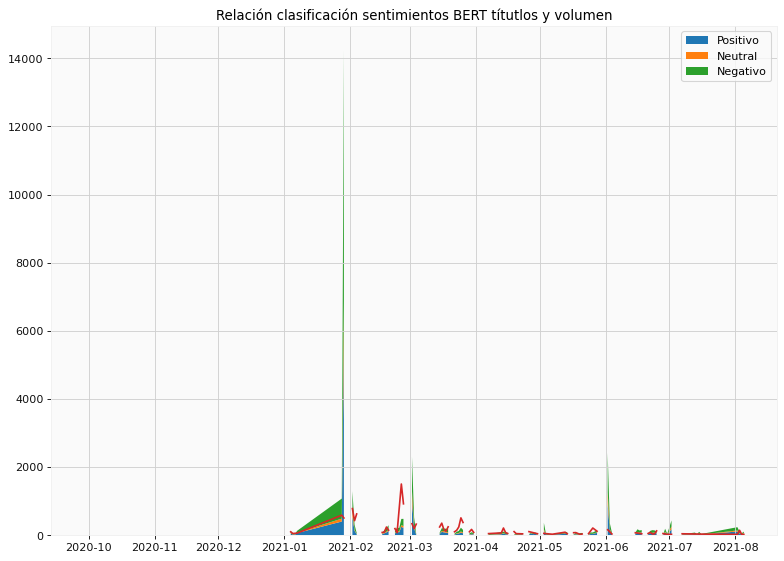

In [73]:
figure(figsize=(11.7,8.27), dpi=80)

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.BERT_title_pos, reddit_gme_date.BERT_title_neu, reddit_gme_date.BERT_title_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos BERT títutlos y volumen')

plt.show()

Repetimos la gráfica pero esta vez limitando el eje y para hacer zoom en la gráfica.

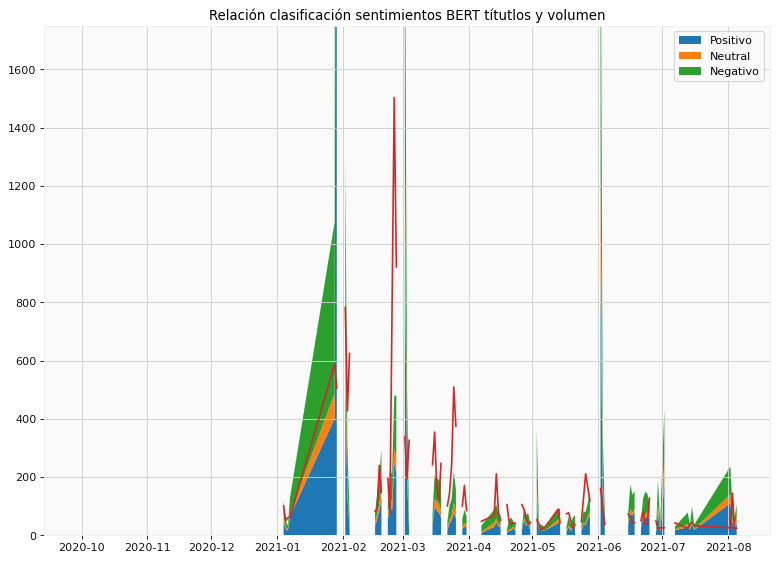

In [74]:
figure(figsize=(11.7,8.27), dpi=80)
axes = plt.gca()

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.BERT_title_pos, reddit_gme_date.BERT_title_neu, reddit_gme_date.BERT_title_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos BERT títutlos y volumen')
axes.set_ylim([0,1750])

plt.show()

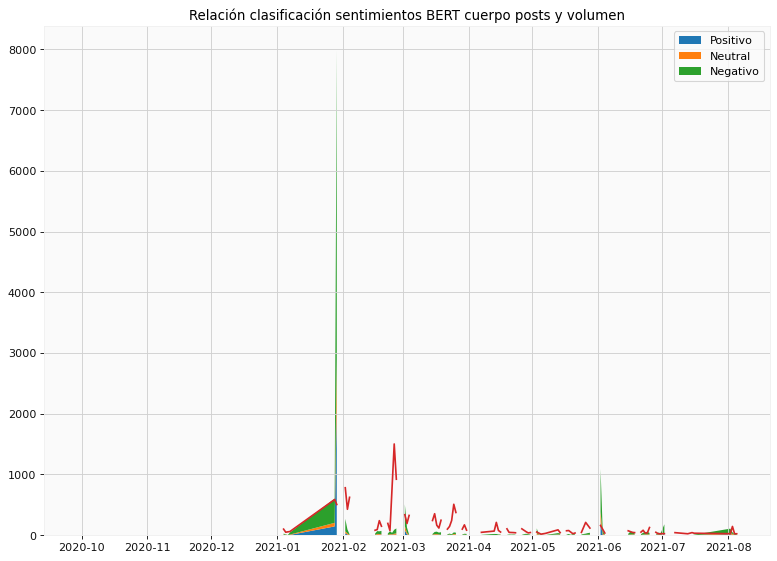

In [75]:
figure(figsize=(11.7,8.27), dpi=80)

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.BERT_body_pos, reddit_gme_date.BERT_body_neu, reddit_gme_date.BERT_body_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos BERT cuerpo posts y volumen')


plt.show()

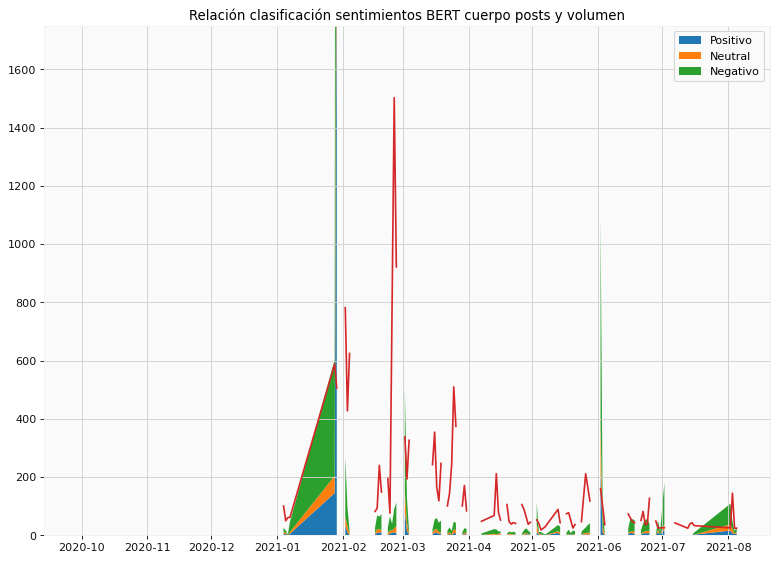

In [76]:
figure(figsize=(11.7,8.27), dpi=80)
axes = plt.gca()

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.BERT_body_pos, reddit_gme_date.BERT_body_neu, reddit_gme_date.BERT_body_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos BERT cuerpo posts y volumen')
axes.set_ylim([0,1750])

plt.show()

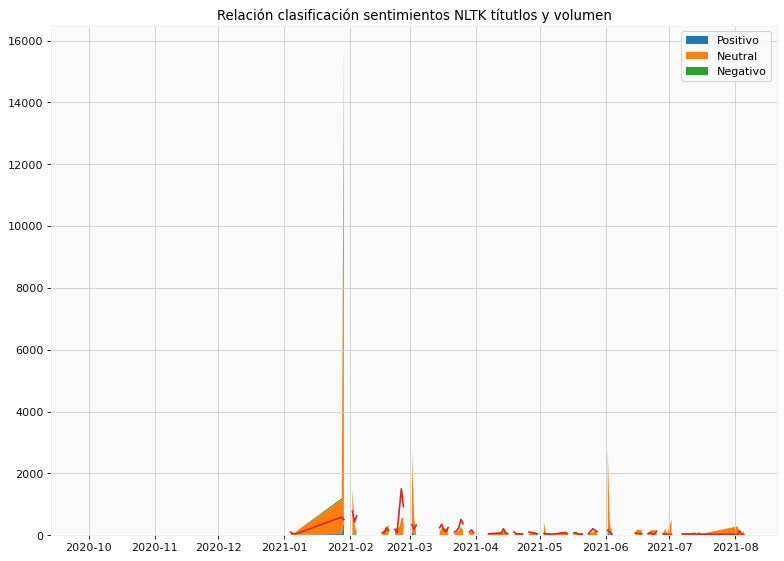

In [77]:
figure(figsize=(11.7,8.27), dpi=80)

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.nltk_title_pos, reddit_gme_date.nltk_title_neu, reddit_gme_date.nltk_title_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos NLTK títutlos y volumen')

plt.show()

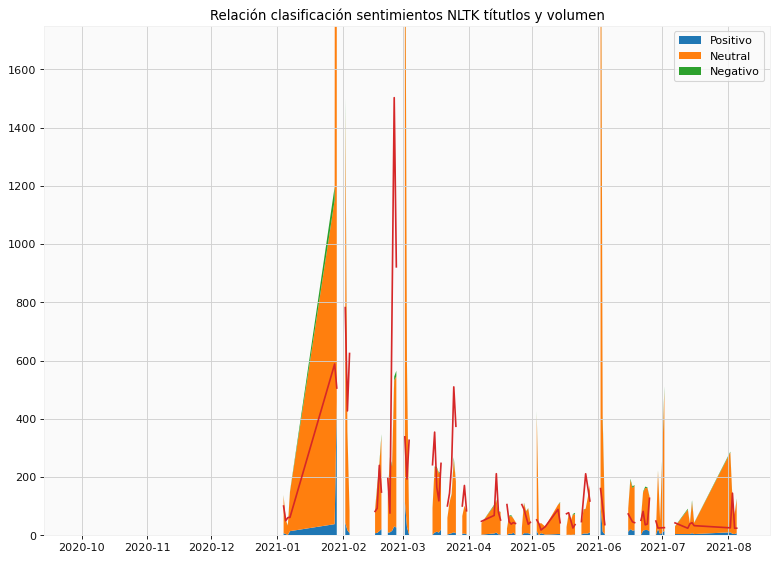

In [78]:
figure(figsize=(11.7,8.27), dpi=80)
axes = plt.gca()

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.nltk_title_pos, reddit_gme_date.nltk_title_neu, reddit_gme_date.nltk_title_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos NLTK títutlos y volumen')
axes.set_ylim([0,1750])

plt.show()

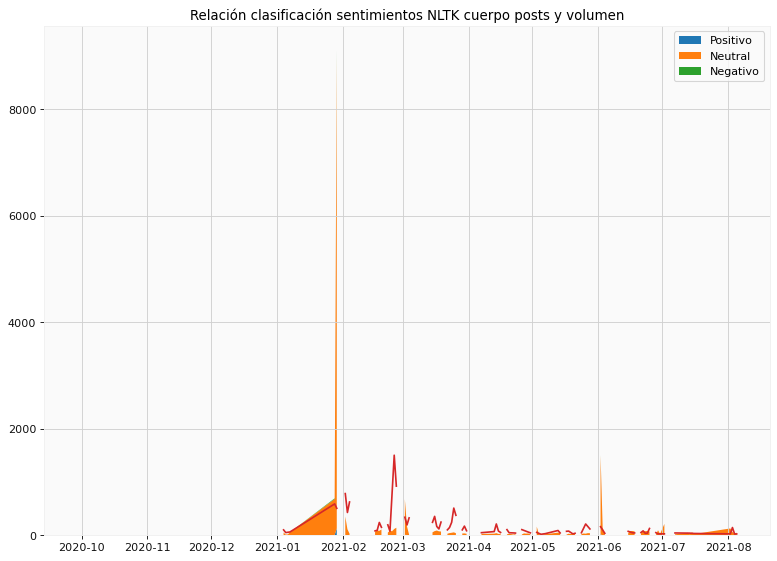

In [79]:
figure(figsize=(11.7,8.27), dpi=80)

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.nltk_body_pos, reddit_gme_date.nltk_body_neu, reddit_gme_date.nltk_body_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos NLTK cuerpo posts y volumen')


plt.show()

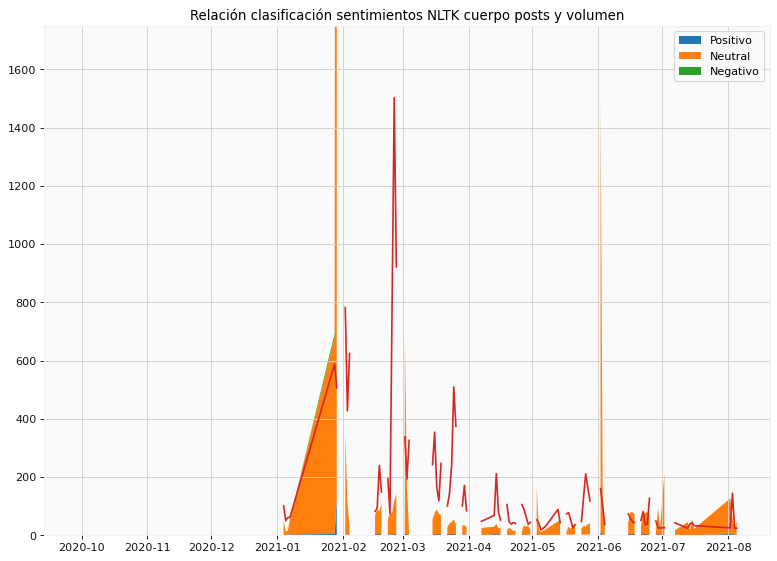

In [80]:
figure(figsize=(11.7,8.27), dpi=80)
axes = plt.gca()

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.nltk_body_pos, reddit_gme_date.nltk_body_neu, reddit_gme_date.nltk_body_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos NLTK cuerpo posts y volumen')
axes.set_ylim([0,1750])


plt.show()

Generamos la matriz de correlación con las variables obtenidas para analizar si existe alguna relación lineal entre alguna de ellas.

In [81]:
reddit_gme_date_corr = reddit_gme_date[['Volume',
                 'Close',
                 'Open',
                 'BERT_title_pos',
                 'BERT_title_likes_pos0,2',
                 'BERT_title_likes_pos0,4',
                 'BERT_title_likes_pos0,6',
                  'BERT_title_coment_pos0,2',
                'BERT_title_coment_pos0,4',
                'BERT_title_coment_pos0,6' ,                     
                 'BERT_title_neu',
                 'BERT_title_likes_neu0,2',
                 'BERT_title_likes_neu0,4',
                 'BERT_title_likes_neu0,6',
                'BERT_title_coment_neu0,2',
                'BERT_title_coment_neu0,4',
                'BERT_title_coment_neu0,6',
                 'BERT_title_neg',
                 'BERT_title_likes_neg0,2',
                 'BERT_title_likes_neg0,4',
                 'BERT_title_likes_neg0,6',
                'BERT_title_coment_neg0,2',
                'BERT_title_coment_neg0,4',
                'BERT_title_coment_neg0,6',
                 'BERT_body_likes_pos0,2',
                 'BERT_body_likes_pos0,4',
                 'BERT_body_likes_pos0,6',
                 'BERT_body_coment_pos0,2',
                'BERT_body_coment_pos0,4',
                'BERT_body_coment_pos0,6',
                 'BERT_body_likes_neu0,2',
                 'BERT_body_likes_neu0,4',
                 'BERT_body_likes_neu0,6',
                'BERT_body_coment_neu0,2',
                'BERT_body_coment_neu0,4',
                'BERT_body_coment_neu0,6',
                 'BERT_body_likes_neg0,2',
                 'BERT_body_likes_neg0,4',
                 'BERT_body_likes_neg0,6',
                 'BERT_body_coment_neg0,2',
                'BERT_body_coment_neg0,4',
                'BERT_body_coment_neg0,6',]].corr(method='pearson')

Representamos de forma gráfica la matriz de correlación utilizando un mapa de calor, para facilitar la visualización.

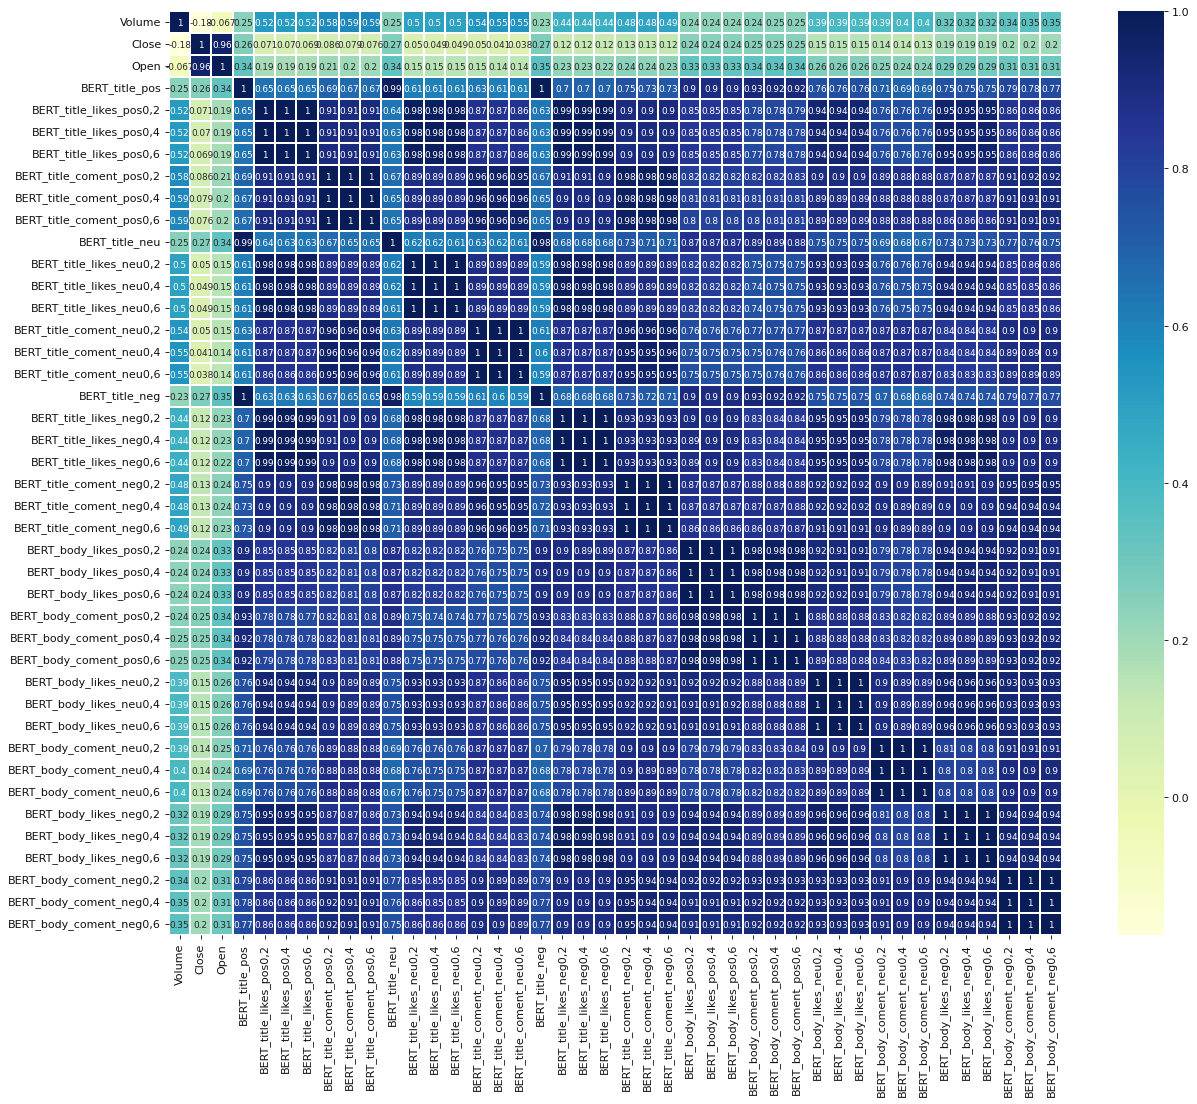

In [82]:
figure(figsize=(18,15), dpi=80)

sns.heatmap(reddit_gme_date_corr, cmap="YlGnBu", annot=True, annot_kws={"size": 8}, linewidths=0.3)

plt.show()

Adicionalmente vamos a analizar las palabras que más se repiten en función del sentimiento del título o post para cada uno de los modelos.

Empezamos por aislar los títulos que han sido identificados como positivos y negativos por el modelo BERT. A continuación concatenamos los títulos en un solo string.

In [83]:
Mas_Positivo_title_BERT = reddit_dataset[reddit_dataset['BERT_score_title'] == 5]['title'].dropna()
Mas_Negativo_title_BERT = reddit_dataset[reddit_dataset['BERT_score_title'] == 1]['title'].dropna()

Mas_Positivo_title_BERT_texto = ' '.join(Mas_Positivo_title_BERT)
Mas_Negativo_title_BERT_texto = ' '.join(Mas_Negativo_title_BERT)

Generamos las nubes de palabras. Son una técnica de representación gráfica que permite visualizar las palabras más utilizadas en una cadena de carácteres. Teniendo las palabras con mayor número de apariciones un mayor tamaño.

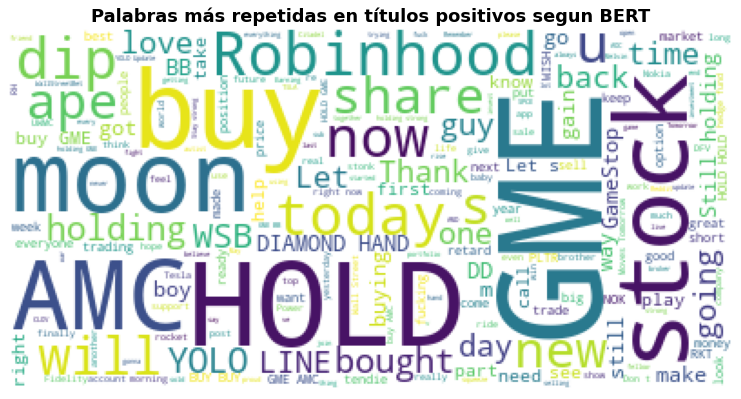

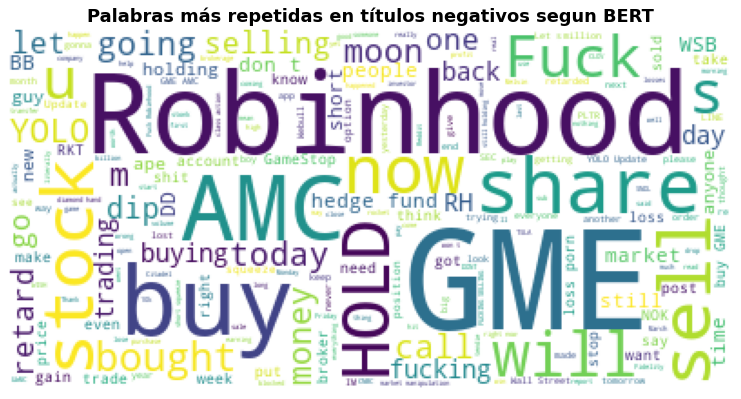

In [84]:
pwc_BERT_title = WordCloud(background_color='white').generate(Mas_Positivo_title_BERT_texto)
nwc_BERT_title = WordCloud(background_color='white').generate(Mas_Negativo_title_BERT_texto)

figure(figsize=(11.7,8.27), dpi=80)
plt.title('Palabras más repetidas en títulos positivos segun BERT',fontsize=16,fontweight='bold')
plt.imshow(pwc_BERT_title)
plt.axis('off')
plt.show()

figure(figsize=(11.7,8.27), dpi=80)
plt.title('Palabras más repetidas en títulos negativos segun BERT',fontsize=16,fontweight='bold')
plt.imshow(nwc_BERT_title)
plt.axis('off')
plt.show()

Aplicando las mismas operaciones generamos las nubes de palabaras para el cuerpo de las publicaciones. 

In [85]:
Mas_Positivo_body_BERT = reddit_dataset[reddit_dataset['BERT_score_body'] == 5]['body'].dropna()
Mas_Negativo_body_BERT = reddit_dataset[reddit_dataset['BERT_score_body']== 1]['body'].dropna()

Mas_Positivo_body_BERT_texto = ' '.join(Mas_Positivo_body_BERT)
Mas_Negativo_body_BERT_texto = ' '.join(Mas_Negativo_body_BERT)

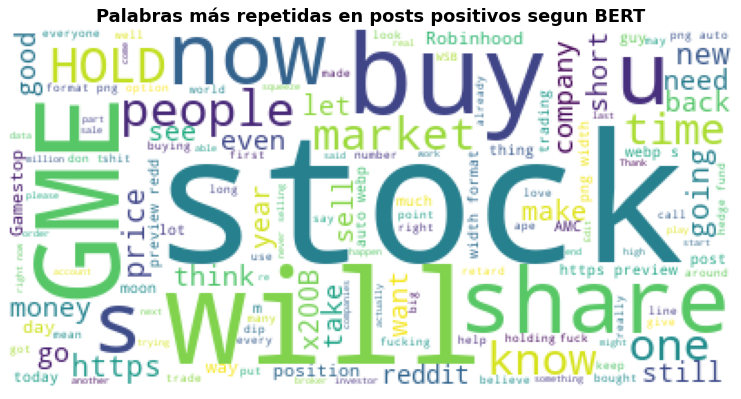

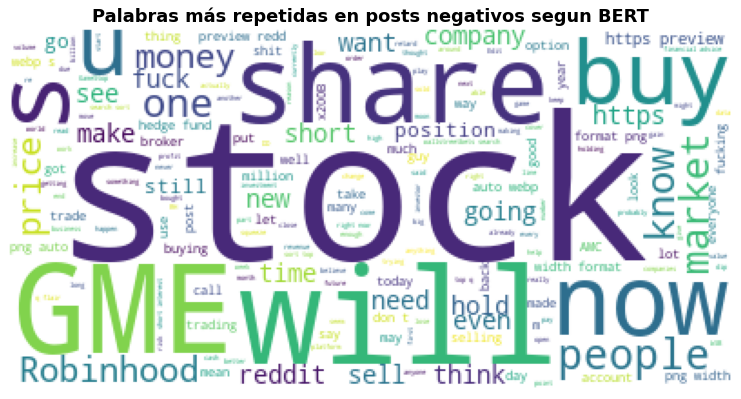

In [86]:
pwc_BERT_body = WordCloud(background_color='white').generate(Mas_Positivo_body_BERT_texto)
nwc_BERT_body = WordCloud(background_color='white').generate(Mas_Negativo_body_BERT_texto)

figure(figsize=(11.7,8.27), dpi=80)
plt.title('Palabras más repetidas en posts positivos segun BERT',fontsize=16,fontweight='bold')
plt.imshow(pwc_BERT_body)
plt.axis('off')
plt.show()

figure(figsize=(11.7,8.27), dpi=80)
plt.title('Palabras más repetidas en posts negativos segun BERT',fontsize=16,fontweight='bold')
plt.imshow(nwc_BERT_body)
plt.axis('off')
plt.show()

De manera simialr generamos las mismas visualizaciones con las pablabras más utilizadas de los títulos y cuerpos de los posts según la librería NLTK.

In [87]:
Mas_Positivo_title_nltk = reddit_dataset[reddit_dataset['nltk_score_title'] == 5]['title'].dropna()
Mas_Negativo_title_nltk = reddit_dataset[reddit_dataset['nltk_score_title'] == 1]['title'].dropna()

Mas_Positivo_title_nltk_texto = ' '.join(Mas_Positivo_title_nltk)
Mas_Negativo_title_nltk_texto = ' '.join(Mas_Negativo_title_nltk)

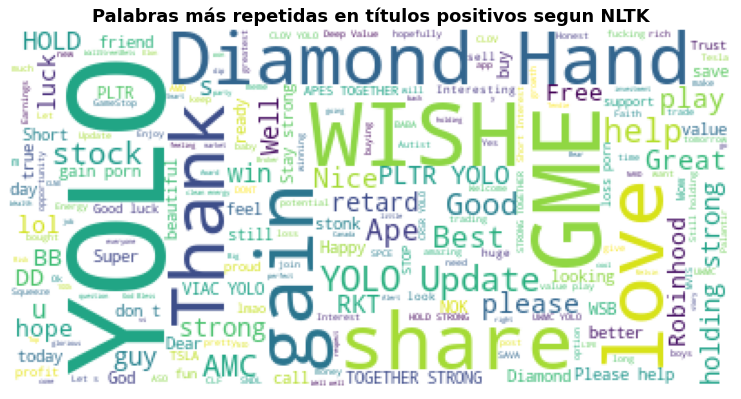

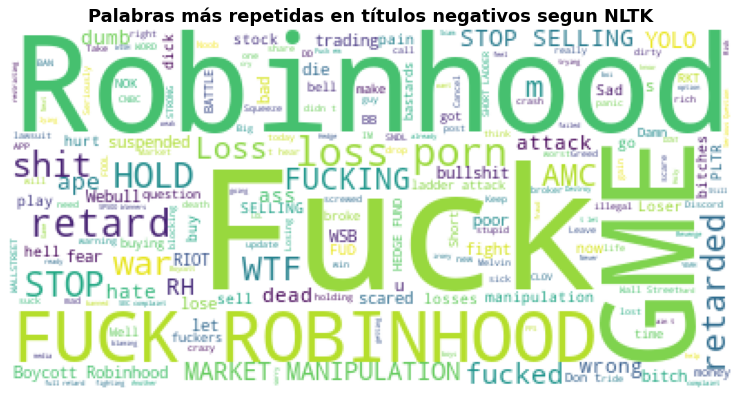

In [88]:
pwc_ntlk_title = WordCloud(background_color='white').generate(Mas_Positivo_title_nltk_texto)
nwc_nltk_title = WordCloud(background_color='white').generate(Mas_Negativo_title_nltk_texto)

figure(figsize=(11.7,8.27), dpi=80)
plt.title('Palabras más repetidas en títulos positivos segun NLTK',fontsize=16,fontweight='bold')
plt.imshow(pwc_ntlk_title)
plt.axis('off')
plt.show()

figure(figsize=(11.7,8.27), dpi=80)
plt.title('Palabras más repetidas en títulos negativos segun NLTK',fontsize=16,fontweight='bold')
plt.imshow(nwc_nltk_title)
plt.axis('off')
plt.show()

In [89]:
Mas_Positivo_body_nltk = reddit_dataset[reddit_dataset['nltk_score_body'] == 5]['body'].dropna()
Mas_Negativo_body_nltk = reddit_dataset[reddit_dataset['nltk_score_body'] == 1]['body'].dropna()

Mas_Positivo_body_nltk_texto = ' '.join(Mas_Positivo_body_nltk)
Mas_Negativo_body_nltk_texto = ' '.join(Mas_Negativo_body_nltk)

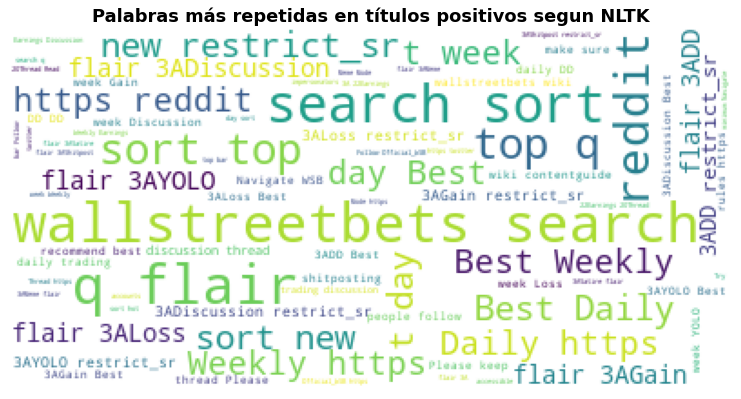

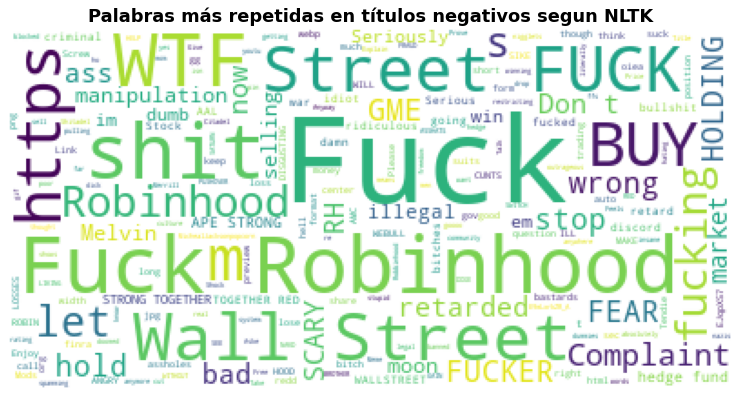

In [90]:
pwc_ntlk_body = WordCloud(background_color='white').generate(Mas_Positivo_body_nltk_texto)
nwc_nltk_body = WordCloud(background_color='white').generate(Mas_Negativo_body_nltk_texto)

figure(figsize=(11.7,8.27), dpi=80)
plt.title('Palabras más repetidas en títulos positivos segun NLTK',fontsize=16,fontweight='bold')
plt.imshow(pwc_ntlk_body)
plt.axis('off')
plt.show()

figure(figsize=(11.7,8.27), dpi=80)
plt.title('Palabras más repetidas en títulos negativos segun NLTK',fontsize=16,fontweight='bold')
plt.imshow(nwc_nltk_body)
plt.axis('off')
plt.show()

# Prueba de convertir imágenes en texto

Para ello primero necesitamos obtener una de las url a las imágenes de nuestro dataset. Tenemos que tener en cuenta que muchas de las url del dataset no son imágenes: pueden ser también videos o enlaces a otros comentarios de reddit. Si queremos utilizar este método tendremos que filtrar el dataset seleccionando solo las imágenes.

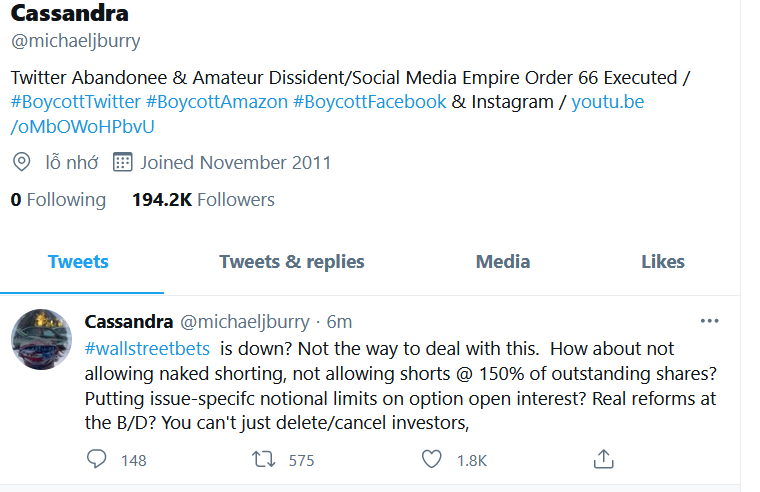

In [91]:
IPython.display.Image(reddit_dataset.url[200], width = 500)

In [92]:
reddit_dataset.url[200]

'https://i.redd.it/fkuzbqii0zd61.png'

In [93]:
url = reddit_dataset.url[200]
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

r = requests.get(url, headers=headers)
img = Image.open(io.BytesIO(r.content))
text = pytesseract.image_to_string(img)

print(text)

NameError: name 'pytesseract' is not defined

Este método resulta eficiente en convertir imágens en texto, sin embargo la utilidad del mismo puede ser cuestionada: muchas de las imágenes son capturas de pantalla de aplicaciones bursátiles o memes que carecen de sentido sin la imagen asociada. Esto es algo que tendremos que tener en cuenta al aplicar el PLN a estos textos.

Próxima tarea: Filtrar las url para obtener un campo solo con imágenes.

## 6.  Modelo de predicción entre sentimientos y precios de la acción <a class="anchor" id="cap6"></a>

In [94]:
reddit_gme_date

score    comms_num  BERT_title_pos  BERT_title_neu  BERT_title_neg  \
0       4.000000    11.000000               0               0               1   
1    4230.302036   531.211538             315              75             371   
2    3044.586466   946.255639              51              15              42   
3    1632.507246   588.021739              48              15              56   
4     197.207547    71.811321              21               6              23   
..           ...          ...             ...             ...             ...   
153  2621.477564   571.711538             106              26             138   
154  3406.000000  1543.893617              19               3              18   
155  1820.152174   542.423913              36              13              33   
156   368.213043   141.239130              85              20              87   
157   713.754717   704.698113              25               5              17   

     BERT_body_pos  BERT_body_neu  BERT_body_neg  nltk_title_pos  \
0                0              0              1               0   
1               31             24            181              27   
2                2              8             31               2   
3                4              4             18               7   
4                4              6              6               4   
..             ...            ...            ...             ...   
153             10              8             24              15   
154              3              2              7               2   
155              1              2             17               5   
156             10              5             29              21   
157              0              0              0               3   

     nltk_title_neu  ...  BERT_body_coment_neg0,2  BERT_body_coment_neg0,4  \
0                 1  ...                 3.200000                 5.400000   
1               839  ...             19410.857692             38640.715385   
2               129  ...              5897.784962             11764.569925   
3               129  ...              2134.878261              4251.756522   
4                48  ...                92.173585               178.347170   
..              ...  ...                      ...                      ...   
153             290  ...              2768.215385              5512.430769   
154              43  ...              2168.451064              4329.902128   
155              86  ...              1861.241304              3705.482609   
156             204  ...               848.186957              1667.373913   
157              49  ...                 0.000000                 0.000000   

     BERT_body_coment_neg0,6       Date  Close      Volume   Open     High  \
0                   7.600000 2020-09-29  10.35   5244339.0  10.00  10.6500   
1               57870.573077        NaT    NaN         NaN    NaN      NaN   
2               17631.354887        NaT    NaN         NaN    NaN      NaN   
3                6368.634783 2021-01-04  17.25  10022470.0  19.00  19.1000   
4                 264.520755 2021-01-05  17.37   4961457.0  17.35  18.0765   
..                       ...        ...    ...         ...    ...      ...   
153              8256.646154        NaT    NaN         NaN    NaN      NaN   
154              6491.353191        NaT    NaN         NaN    NaN      NaN   
155              5549.723913        NaT    NaN         NaN    NaN      NaN   
156              2486.560870        NaT    NaN         NaN    NaN      NaN   
157                 0.000000        NaT    NaN         NaN    NaN      NaN   

       Low  week_day  
0     9.93   Tuesday  
1      NaN       NaN  
2      NaN       NaN  
3    17.15    Monday  
4    17.23   Tuesday  
..     ...       ...  
153    NaN       NaN  
154    NaN       NaN  
155    NaN       NaN  
156    NaN       NaN  
157    NaN       NaN  

[158 rows x 61 columns]

In [95]:
#Árbol de decisión
!pip install sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Definimos cuales erán nuestras variables predictoras y cuál nuestra variable respuesta de acuerdo a la matriz de correlación.
El modelo de predicción tendrá como variables regresoras las ponderaciones de los sentimientos de los títulos en función de los "likes" medios de cada uno.
La variable respuesta será el precio de Apertura.

In [96]:
reddit_gme_date_prueba = reddit_gme_date.copy().dropna(subset = ['Open'])

In [97]:
X = reddit_gme_date_prueba[[
    'BERT_title_likes_pos0,2',
    'BERT_title_likes_pos0,4','BERT_title_likes_pos0,6',
    'BERT_title_likes_neu0,2',
    'BERT_title_likes_neu0,4','BERT_title_likes_neu0,6',
    'BERT_title_likes_neg0,2','BERT_title_likes_neg0,4',
    'BERT_title_likes_neg0,6']]
y = reddit_gme_date_prueba[['Open', 'Date']]
y['Open'].mean()

166.37517391304348

Ponderamos aquellos valores nulos de la Variable Open "Precio de Apertura"

In [98]:
#y=y.fillna(166.37)
y

Open       Date
0     10.00 2020-09-29
3     19.00 2021-01-04
4     17.35 2021-01-05
5     17.34 2021-01-06
6     18.47 2021-01-07
..      ...        ...
129  170.15 2021-07-16
130  162.00 2021-08-02
131  156.74 2021-08-03
132  152.73 2021-08-04
133  148.00 2021-08-05

[92 rows x 2 columns]

Dividimos nuestra data en entrenamiento 80% y prueba 20%

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        #y.values.reshape(-1,1),
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

Creamos nuestro modelo

In [100]:
modelo = DecisionTreeRegressor(
            max_depth         = 5,
            random_state      = 123
          )

In [101]:
modelo.fit(X_train,y_train['Open'])

DecisionTreeRegressor(max_depth=5, random_state=123)

Después de entrenar nuestro modelo calculamos su precisión a través del RMSE de las predicciones

In [102]:
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test['Open'],
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 51.22924296621739


Visualizamos nuestro árbol entrenado

Profundidad del árbol: 5
Número de nodos terminales: 9


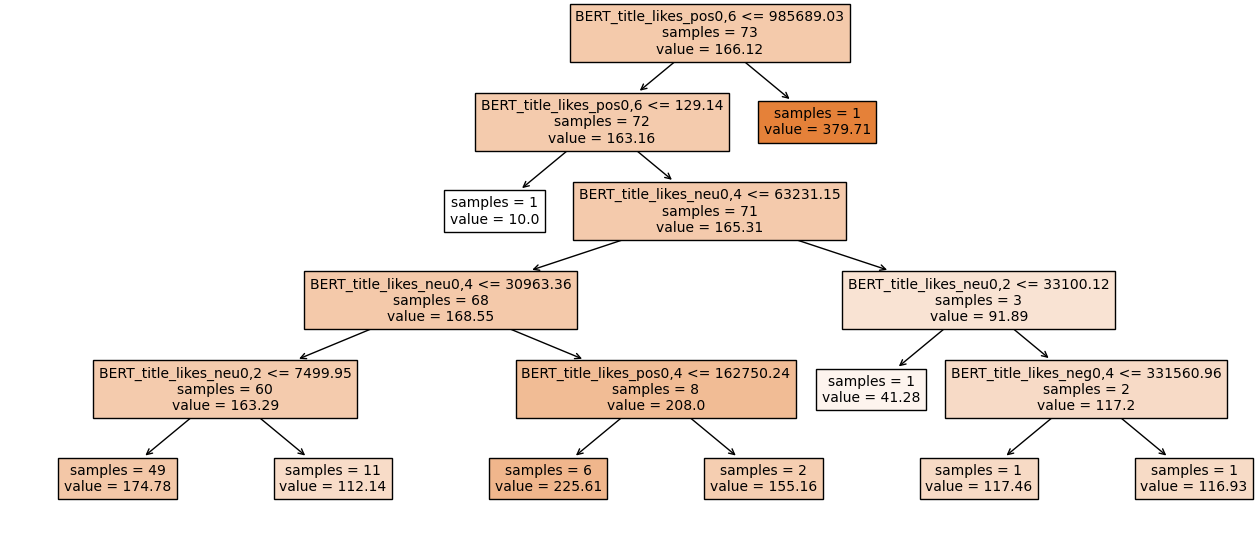

In [103]:
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = X_test.columns,
            class_names   = 'y_test',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

Evaluamos la importancia de los predictores

In [104]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_test.columns,
                             'importancia %': modelo.feature_importances_*100}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia %', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia %
2  BERT_title_likes_pos0,6      47.462134
3  BERT_title_likes_neu0,2      26.488865
4  BERT_title_likes_neu0,4      21.003534
1  BERT_title_likes_pos0,4       5.045373
7  BERT_title_likes_neg0,4       0.000095
0  BERT_title_likes_pos0,2       0.000000
5  BERT_title_likes_neu0,6       0.000000
6  BERT_title_likes_neg0,2       0.000000
8  BERT_title_likes_neg0,6       0.000000

## 7. Conclusiones <a class="anchor" id="cap7"></a>